In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv("battery_life_first_50_cycles.csv")

print(df)

            IR        QC        QD       Tavg       Tmin       Tmax  \
0     0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1     0.016742  1.071042  1.070689  31.875011  29.566130  35.652016   
2     0.016724  1.071674  1.071900  31.931490  29.604385  35.692978   
3     0.016681  1.072304  1.072510  31.932603  29.744202  35.680588   
4     0.016662  1.072970  1.073174  31.959322  29.644709  35.728691   
...        ...       ...       ...        ...        ...        ...   
6995  0.015602  1.071451  1.071640  32.750094  30.891405  34.619160   
6996  0.015595  1.071707  1.071866  32.754391  30.828009  34.740250   
6997  0.015583  1.071824  1.072039  32.790772  30.861229  34.741764   
6998  0.015592  1.071991  1.072053  32.832211  30.947521  34.724735   
6999  0.015575  1.071953  1.072145  32.863722  31.025038  34.791729   

      chargetime  cycle battery_id   C1    Q1   C2  cycle_life  
0       0.000000    1.0       b1c0  3.6  80.0  3.6      1190.0  
1      13.341250 

In [2]:
cols_to_check = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']

Q1 = df[cols_to_check].quantile(0.25)
Q3 = df[cols_to_check].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 2.4 * IQR
upper_bound = Q3 + 2.4 * IQR

mask = ~((df[cols_to_check] < lower_bound) | (df[cols_to_check] > upper_bound)).any(axis=1)
df_cleaned = df[mask]


In [3]:
df_cleaned.shape

(6486, 13)

In [4]:
import pandas as pd

# 1️  Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️  Keep only batteries with at least 20 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️ Sort and keep only first 50 cycles per battery
df_50_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(300)
    .reset_index(drop=True)
)

#  Result summary
print("Final shape:", df_50_cycles.shape)
print("Unique batteries:", df_50_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_50_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

Final shape: (6470, 13)
Unique batteries: 131
Imputation complete. Any NAs remaining? False


In [5]:
df_50_cycles=df_imputed.copy()

In [6]:
df_imputed.copy()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,0.015783,1.072993,1.073291,33.094900,31.306654,35.139908,10.041060,46.0,b3c9,5.3,54.0,4.0,1039.0
6466,0.015766,1.072997,1.073233,33.145761,31.352578,35.165241,10.041038,47.0,b3c9,5.3,54.0,4.0,1039.0
6467,0.015773,1.072968,1.073333,33.184021,31.444122,35.213142,10.041152,48.0,b3c9,5.3,54.0,4.0,1039.0
6468,0.015766,1.072948,1.073181,33.183359,31.407549,35.177643,10.040618,49.0,b3c9,5.3,54.0,4.0,1039.0


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=100,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


['qt_y_transformer.pkl']

In [8]:
df_50_cycles=df_imputed.copy()

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=300,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg

agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


['qt_y_transformer.pkl']

In [10]:
pd.DataFrame(X_train_q)
pd.DataFrame(X_train_q).shape

(104, 38)

In [11]:
all_apes=[]

 QT + CIR Evaluation:
MAE  : 160.9 cycles
RMSE : 239.1 cycles
R²   : 0.496
APE  : 17.2%


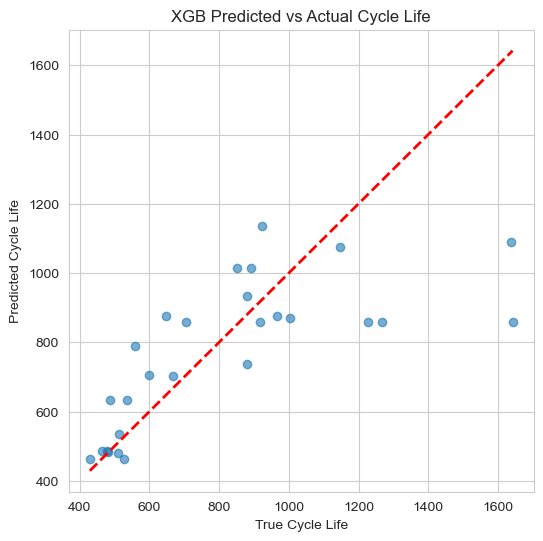

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
import numpy as np

# 1. Base Regression Model (Quantile-Transformed inputs)
modelX = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelX.fit(X_train_q, y_train_q)
y_pred_q = modelX.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
XGB_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print(" QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB_RAW_ape:.1f}%")
all_apes.append(f"XGB_300_APE  : {XGB_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGB Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()


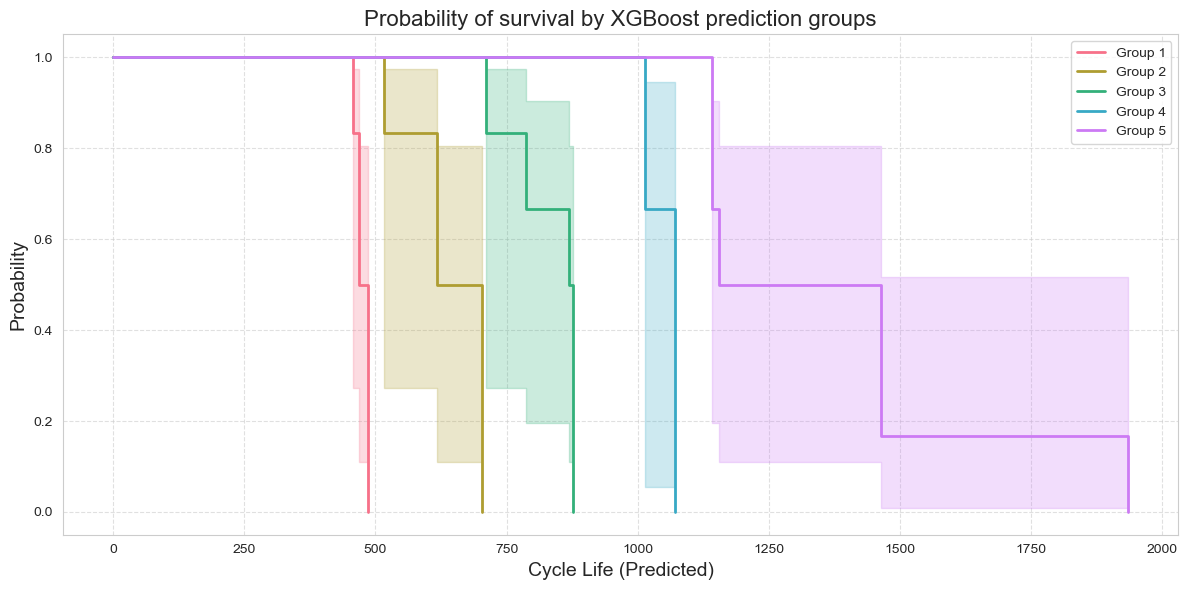

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Assuming y_pred_final already exists from your XGB code
# Step 1: Bin into 5 quantile-based groups
df = pd.DataFrame({'predicted': y_pred_final})
df['group'] = pd.qcut(df['predicted'], q=5, labels=False) + 1  # group labels 1–5

# Step 2: Plot using Kaplan-Meier
plt.figure(figsize=(12, 6))
kmf = KaplanMeierFitter()
colors = sns.color_palette("husl", n_colors=5)

for i in range(1, 6):
    group_durations = df[df['group'] == i]['predicted'].values
    event_observed = np.ones_like(group_durations)  # all observed

    kmf.fit(group_durations, event_observed, label=f"Group {i}")
    kmf.plot(ci_show=True, color=colors[i - 1], linewidth=2)

plt.title("Probability of survival by XGBoost prediction groups", fontsize=16)
plt.xlabel("Cycle Life (Predicted)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 38
[LightGBM] [Info] Start training from score 0.500093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


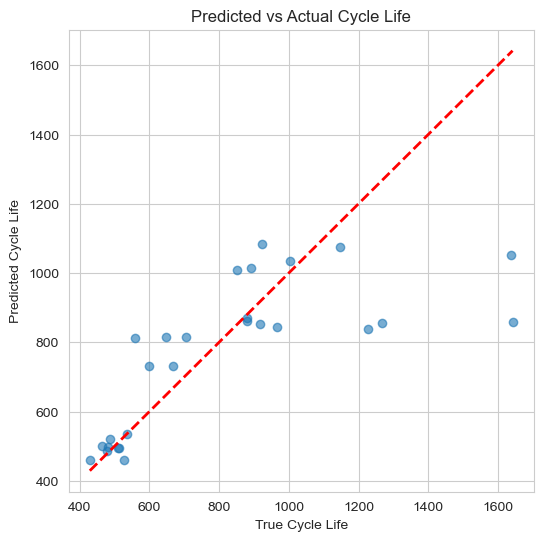

In [15]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

modelL = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelL.fit(X_train_q, y_train_q)
y_pred_q = modelL.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array
# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
LGBM_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_RAW_ape:.1f}%")
all_apes.append(f"LGBM_300_APE  : {LGBM_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 1
[LightGBM] [Info] Start training from score 0.138108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


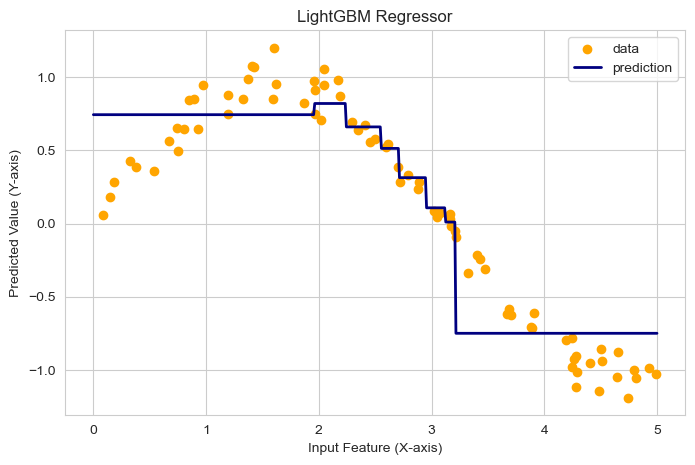

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# -------------------------------
# 🎯 Step 1: Create Sample Data
# -------------------------------

# X-axis values (input features): Random values between 0 and 5
# These represent the input feature (e.g., time, cycle number)
X = np.sort(5 * np.random.rand(80, 1), axis=0)

# Y-axis values (targets): Sine of X values + some noise
# These represent the target variable to predict (e.g., battery capacity, cycle life)
y = np.sin(X).ravel() + 0.1 * np.random.randn(80)

# -------------------------------
# 🧠 Step 2: Train LightGBM Model
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a LightGBM regressor
lgb_reg = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=100)
lgb_reg.fit(X_train, y_train)

# -------------------------------
# 📈 Step 3: Predict and Plot
# -------------------------------

# Generate evenly spaced values on X-axis for smooth prediction line
X_plot = np.linspace(0, 5, 500).reshape(-1, 1)
y_plot = lgb_reg.predict(X_plot)

# -------------------------------
# 🎨 Plotting the Graph
# -------------------------------
plt.figure(figsize=(8, 5))

# Plot actual data points
plt.scatter(X, y, c='orange', label='data')

# Plot predicted line
plt.plot(X_plot, y_plot, color='navy', linewidth=2, label='prediction')

# Title and labels
plt.title("LightGBM Regressor")

# X-axis label: Feature input (e.g., time, voltage, etc.)
plt.xlabel("Input Feature (X-axis)")

# Y-axis label: Target prediction (e.g., cycle life, capacity, etc.)
plt.ylabel("Predicted Value (Y-axis)")

plt.legend()
plt.grid(True)
plt.show()



✅ QT + CIR Evaluation:
MAE  : 217.4 cycles
RMSE : 333.3 cycles
R²   : 0.021
DECISION_TREE_RAW_APE  : 28.1%


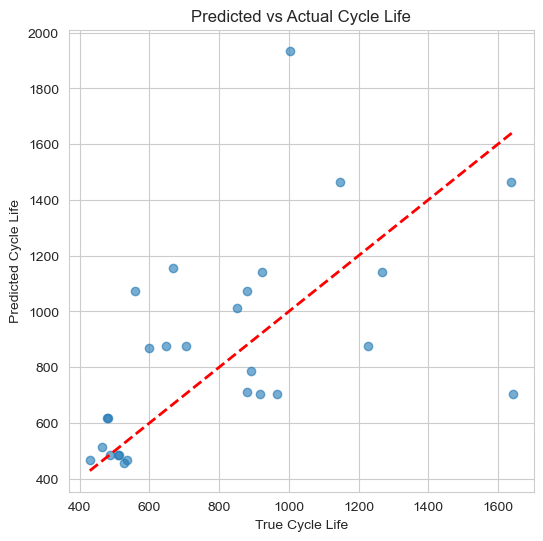

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# 3. Train DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train_q, y_train_q)
y_pred_q = tree.predict(X_test_q)

# 4. (Optional) Apply CIR for monotonic correction
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 5. Inverse-transform predictions
# Skip CIR if you don't want it: use y_pred_q directly
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 6. Evaluate performance
mse = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)
DECISION_TREE_RAW_APE= np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"DECISION_TREE_RAW_APE  : {DECISION_TREE_RAW_APE:.1f}%")
all_apes.append(f"DECISION_TREE_300_APE  : {DECISION_TREE_RAW_APE:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()

In [20]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# # ✅ Step 1: Define model names
# models = ["XGBoost", "LightGBM", "KNN", "Decision Tree"]
#
# # ✅ Step 2: Fill in your actual evaluation results here
# # (Use your real results from previous model runs)
# mae_values = [160.9, 158.3, 175.2, 180.1]
# rmse_values = [198.7, 192.5, 210.4, 215.6]
# r2_values = [0.872, 0.880, 0.842, 0.835]
# ape_values = [8.7, 8.3, 9.5, 9.9]
#
# # ✅ Step 3: Create subplots
# fig, axs = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle("📊 Model Performance Comparison", fontsize=18)
#
# # Plot 1: MAE
# axs[0, 0].bar(models, mae_values, color='skyblue')
# axs[0, 0].set_title("Mean Absolute Error (MAE)")
# axs[0, 0].set_ylabel("Cycles")
#
# # Plot 2: RMSE
# axs[0, 1].bar(models, rmse_values, color='lightcoral')
# axs[0, 1].set_title("Root Mean Squared Error (RMSE)")
# axs[0, 1].set_ylabel("Cycles")
#
# # Plot 3: R² Score
# axs[1, 0].bar(models, r2_values, color='mediumseagreen')
# axs[1, 0].set_title("R² Score")
# axs[1, 0].set_ylim([0.7, 1.0])  # for better visual scaling
#
# # Plot 4: APE (%)
# axs[1, 1].bar(models, ape_values, color='orange')
# axs[1, 1].set_title("Absolute Percentage Error (APE)")
# axs[1, 1].set_ylabel("%")
#
# # ✅ Final Touches
# for ax in axs.flat:
#     ax.grid(True, linestyle='--', alpha=0.5)
#     ax.set_xticklabels(models, rotation=15)
#
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


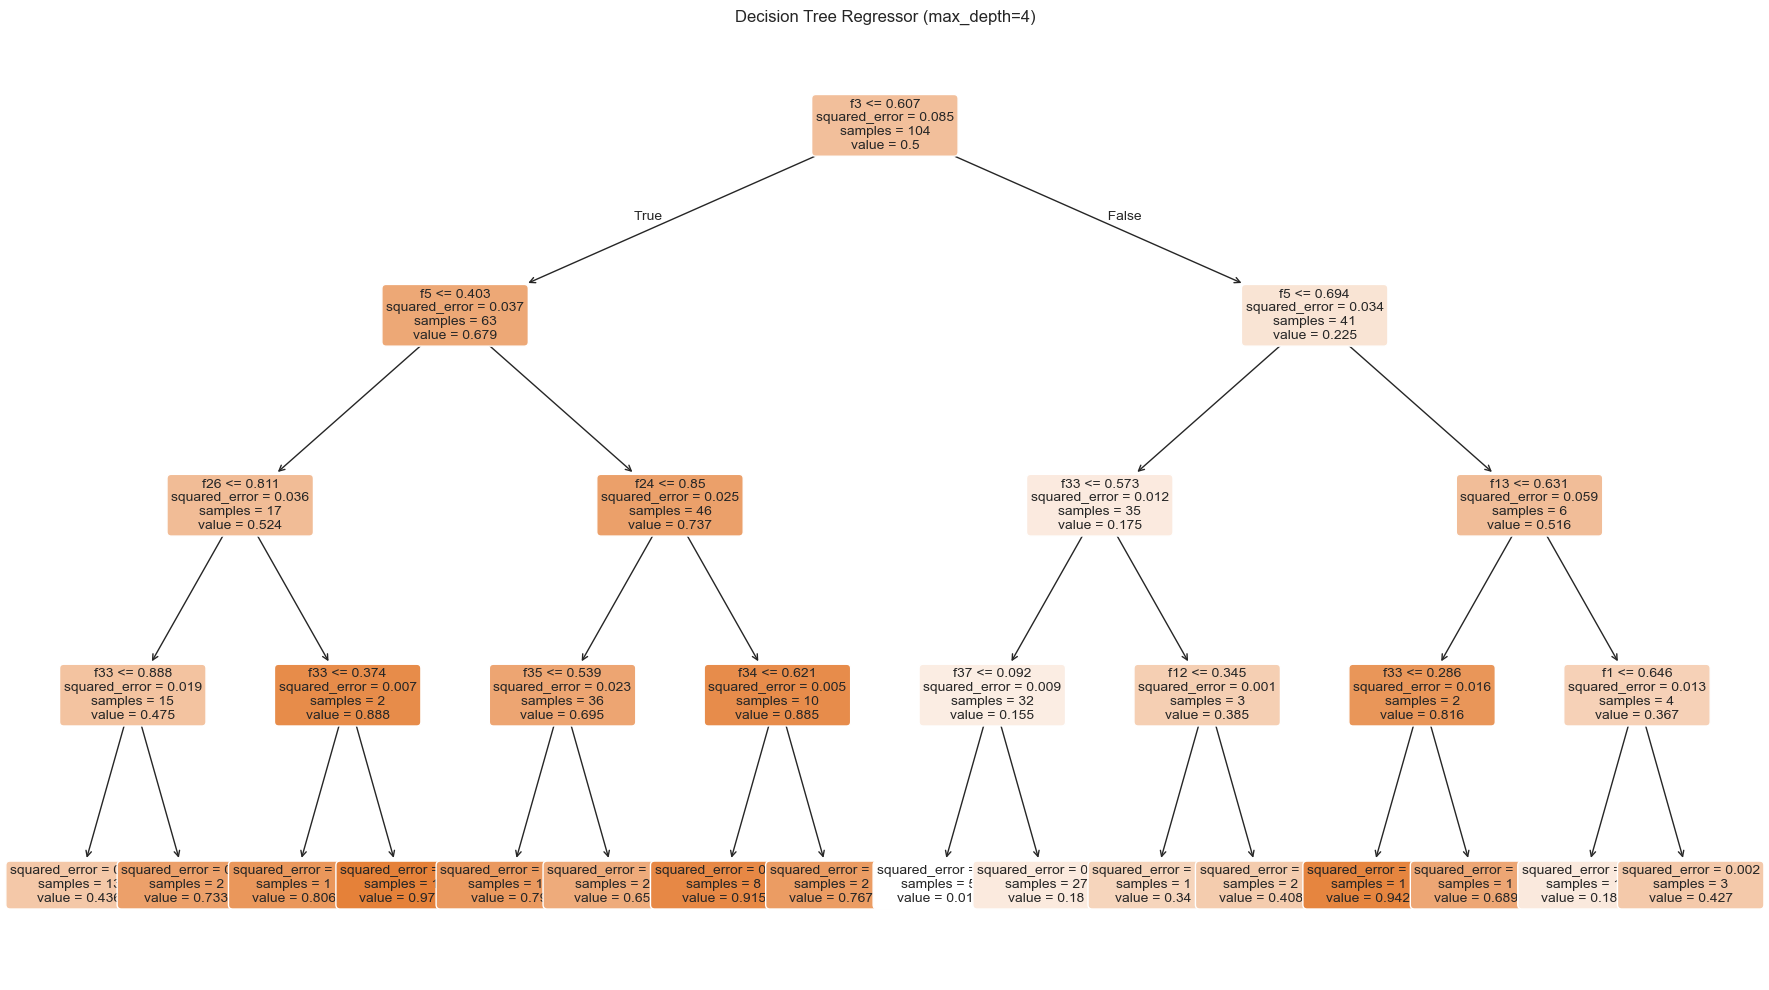

In [21]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Train the Decision Tree
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train_q, y_train_q)

# Generate generic feature names if X_train_q is a NumPy array
feature_names = [f"f{i}" for i in range(X_train_q.shape[1])]

# Plot the tree
plt.figure(figsize=(18, 10))
plot_tree(
    dtree,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=True
)
plt.title("Decision Tree Regressor (max_depth=4)")
plt.tight_layout()
plt.show()



🤝 KNN Regression + QT:
MAE  : 137.3 cycles
RMSE : 211.3 cycles
R²   : 0.606
APE  : 14.8%


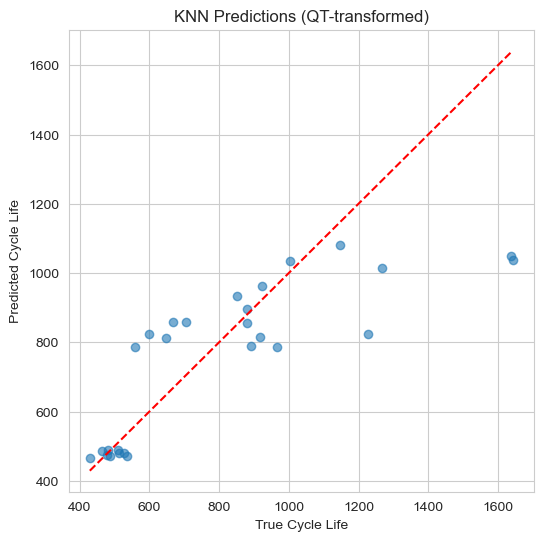

In [60]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train_q, X_test_q, y_train, y_test, qt_y defined already

# 1️⃣ Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_q, y_train_q)

# 2️⃣ Prediction
y_pred_q = knn.predict(X_test_q)

# 3️⃣ Inverse-transform predictions
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝 KNN Regression + QT:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN_RAW_APE:.1f}%")
all_apes.append(f"KNN_300_APE : {DECISION_TREE_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions (QT-transformed)")
plt.grid(True)
plt.show()

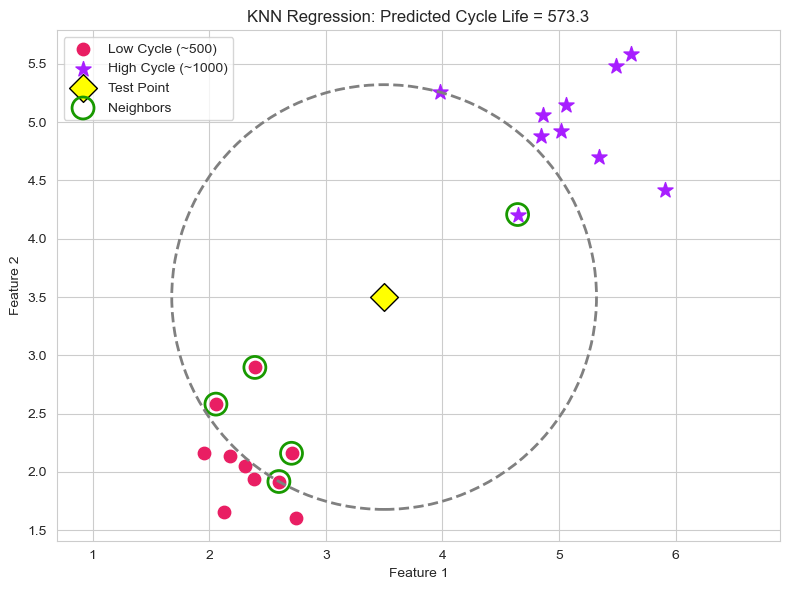

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

# 1️⃣ Simulated training data
np.random.seed(0)
X_train = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.4, size=(10, 2)),   # Cluster A
    np.random.normal(loc=[5, 5], scale=0.4, size=(10, 2))    # Cluster B
])
y_train = np.concatenate([
    np.random.normal(loc=500, scale=30, size=10),    # Cycle life ~500
    np.random.normal(loc=1000, scale=30, size=10)])    # Cycle life ~1000])

# 2️⃣ New test point
X_test = np.array([[3.5, 3.5]])  # Yellow diamond

# 3️⃣ Train KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# 4️⃣ Find neighbors
distances = np.linalg.norm(X_train - X_test, axis=1)
neighbor_idx = distances.argsort()[:5]
neighbors = X_train[neighbor_idx]

# 5️⃣ Plot
plt.figure(figsize=(8, 6))

# Cluster A
plt.scatter(X_train[:10, 0], X_train[:10, 1], color='#E91E63', label='Low Cycle (~500)', s=80)

# Cluster B
plt.scatter(X_train[10:, 0], X_train[10:, 1], color='#a71eff', marker='*', label='High Cycle (~1000)', s=130)

# Test point
plt.scatter(X_test[0, 0], X_test[0, 1], color='yellow', edgecolor='black', label='Test Point', marker='D', s=200, zorder=5)

# Neighbors (highlighted)
plt.scatter(neighbors[:, 0], neighbors[:, 1], facecolors='none', edgecolors='#189900', s=250, linewidths=2, label='Neighbors')

# Circle around test point
radius = distances[neighbor_idx[-1]]
circle = plt.Circle((X_test[0, 0], X_test[0, 1]), radius, color='gray', fill=False, linestyle='--', linewidth=2)
plt.gca().add_patch(circle)

# Labels and legend
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"KNN Regression: Predicted Cycle Life = {y_pred[0]:.1f}")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn import neighbors
#
# # 🔷 Use first 2 features from your dataset for 2D visualization
# X_vis = X_train_q[:, :2]   # Make sure X_train_q exists and has at least 2 features
# y_vis = y_train            # This should be categorical (e.g., 0, 1, 2) for classification
#
# # Mesh step size
# h = 0.02
#
# # Color maps
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
# cmap_bold  = ListedColormap(['#880000', '#006400', '#000088'])
#
# # Plot both uniform and distance weighting in KNN
# for i, weights in enumerate(['uniform', 'distance']):
#     plt.subplot(1, 2, i + 1)
#
#     # Fit KNN classifier
#     clf = neighbors.KNeighborsClassifier(n_neighbors=11, weights=weights)
#     clf.fit(X_vis, y_vis)
#
#     # Create mesh grid
#     x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
#     y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
#
#     # Plot decision boundary
#     plt.contourf(xx, yy, Z, cmap=cmap_light)
#
#     # Plot data points
#     plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=cmap_bold, edgecolor='k', s=40)
#     plt.title(f"3-Class classification\n(k=11, weights='{weights}')")
#     plt.xlabel("Feature 1")
#     plt.ylabel("Feature 2")
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#
# plt.tight_layout()
# plt.show()


In [27]:
pd.DataFrame(X_test_q[:200])


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.740822,0.725894,0.773499,0.736615,0.901697,0.889442,0.210771,0.895282,0.748049,0.776112,...,0.497838,0.214226,0.095480,0.000000,0.177507,0.387933,0.364654,0.569966,0.694740,0.463038
1,0.600476,0.264396,0.623398,0.548115,0.345455,0.339770,0.623503,0.977854,0.428929,0.976154,...,0.567679,0.739106,0.953619,0.645784,0.299420,0.845439,0.913883,0.768633,0.565151,0.257069
2,0.469021,0.267502,0.455577,0.416481,0.058651,0.129750,0.855269,0.895185,0.662987,0.862998,...,0.260286,0.451950,1.000000,0.991251,0.971066,0.931237,0.121331,0.021744,0.082956,0.507181
3,0.556308,0.274946,0.594931,0.519705,0.284894,0.302713,0.880163,0.937932,0.141123,0.947836,...,0.412881,0.953743,0.917634,0.883310,0.302990,0.851311,0.970834,0.449436,0.170081,0.059178
4,0.060648,0.441585,0.065562,0.064392,0.655817,0.544229,0.403967,0.089393,0.229694,0.096516,...,0.739805,0.691823,0.516308,0.000000,0.909517,0.611710,0.439449,0.780251,0.909357,0.655870
5,0.805835,0.901248,0.787041,0.851616,0.463732,0.369751,0.066989,0.620829,0.381327,0.633798,...,0.258696,0.187101,0.142733,0.151374,0.132056,0.159525,0.189807,0.298641,0.503147,0.658920
6,0.768982,0.802492,0.779743,0.755966,0.670854,0.551566,0.145636,0.465822,0.729736,0.338982,...,0.454565,0.148380,0.161011,0.049501,0.245169,0.313003,0.221959,0.310651,0.514527,0.742913
7,0.033723,0.486172,0.037281,0.040200,0.907953,0.884808,0.445816,0.115367,0.439809,0.116253,...,0.827498,0.305322,0.308053,0.207458,0.550298,0.523801,0.537965,0.793416,0.827681,0.350001
8,0.941429,0.644026,0.948552,0.867108,0.222331,0.304388,0.981280,0.643830,0.917917,0.462583,...,0.261712,0.486386,0.802921,0.541033,0.101235,0.362897,0.424347,0.293391,0.910098,0.552398
9,0.482095,0.193332,0.490427,0.439835,0.197865,0.127438,0.952587,0.765894,0.148600,0.846107,...,0.575205,0.779389,0.953627,0.973969,0.458699,0.925654,0.680915,0.783928,0.404367,0.061019


In [28]:
agg.columns

Index(['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis',
       'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew',
       'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max',
       'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std',
       'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend',
       'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0',
       'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0',
       'Tavg_hist_1', 'Tavg_hist_2', 'Tavg_hist_3', 'Tavg_hist_4',
       'cycle_life'],
      dtype='object')

In [29]:
pd.DataFrame(X_test_q)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.740822,0.725894,0.773499,0.736615,0.901697,0.889442,0.210771,0.895282,0.748049,0.776112,...,0.497838,0.214226,0.095480,0.000000,0.177507,0.387933,0.364654,0.569966,0.694740,0.463038
1,0.600476,0.264396,0.623398,0.548115,0.345455,0.339770,0.623503,0.977854,0.428929,0.976154,...,0.567679,0.739106,0.953619,0.645784,0.299420,0.845439,0.913883,0.768633,0.565151,0.257069
2,0.469021,0.267502,0.455577,0.416481,0.058651,0.129750,0.855269,0.895185,0.662987,0.862998,...,0.260286,0.451950,1.000000,0.991251,0.971066,0.931237,0.121331,0.021744,0.082956,0.507181
3,0.556308,0.274946,0.594931,0.519705,0.284894,0.302713,0.880163,0.937932,0.141123,0.947836,...,0.412881,0.953743,0.917634,0.883310,0.302990,0.851311,0.970834,0.449436,0.170081,0.059178
4,0.060648,0.441585,0.065562,0.064392,0.655817,0.544229,0.403967,0.089393,0.229694,0.096516,...,0.739805,0.691823,0.516308,0.000000,0.909517,0.611710,0.439449,0.780251,0.909357,0.655870
5,0.805835,0.901248,0.787041,0.851616,0.463732,0.369751,0.066989,0.620829,0.381327,0.633798,...,0.258696,0.187101,0.142733,0.151374,0.132056,0.159525,0.189807,0.298641,0.503147,0.658920
6,0.768982,0.802492,0.779743,0.755966,0.670854,0.551566,0.145636,0.465822,0.729736,0.338982,...,0.454565,0.148380,0.161011,0.049501,0.245169,0.313003,0.221959,0.310651,0.514527,0.742913
7,0.033723,0.486172,0.037281,0.040200,0.907953,0.884808,0.445816,0.115367,0.439809,0.116253,...,0.827498,0.305322,0.308053,0.207458,0.550298,0.523801,0.537965,0.793416,0.827681,0.350001
8,0.941429,0.644026,0.948552,0.867108,0.222331,0.304388,0.981280,0.643830,0.917917,0.462583,...,0.261712,0.486386,0.802921,0.541033,0.101235,0.362897,0.424347,0.293391,0.910098,0.552398
9,0.482095,0.193332,0.490427,0.439835,0.197865,0.127438,0.952587,0.765894,0.148600,0.846107,...,0.575205,0.779389,0.953627,0.973969,0.458699,0.925654,0.680915,0.783928,0.404367,0.061019


In [30]:
import pandas as pd
import numpy as np

# Step 1: Prepare original feature columns
original_cols = agg.drop(columns=['cycle_life']).columns.tolist()

# Step 2: Drop target and apply IterativeImputer
X = agg.drop(columns=['cycle_life'])
X_imputed = iter_imp.fit_transform(X)

# Step 3: Handle dropped columns gracefully
# Only keep columns that did NOT become all-NaN or caused failure in IterativeImputer
retained_col_count = X_imputed.shape[1]

# Step 4: Identify which columns were dropped
retained_cols = original_cols[:retained_col_count]  # safe assumption: IterativeImputer returns in order but drops tailing NaN cols
dropped_cols = list(set(original_cols) - set(retained_cols))

# Step 5: Print
print(f"✅ Retained ({len(retained_cols)}):", retained_cols)
print(f"❌ Dropped ({len(dropped_cols)}):", dropped_cols)

# Step 6: Proceed with retained_cols for further work
X_imputed_df = pd.DataFrame(X_imputed, columns=retained_cols)


✅ Retained (38): ['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0']
❌ Dropped (4): ['Tavg_hist_3', 'Tavg_hist_1', 'Tavg_hist_2', 'Tavg_hist_4']


C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [31]:
print("Final columns after imputation:")
print(X_imputed_df.columns.tolist())
print(f"\nTotal number of retained columns: {len(X_imputed_df.columns)}")

Final columns after imputation:
['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0']

Total number of retained columns: 38


  0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_7528\2313672321.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df)


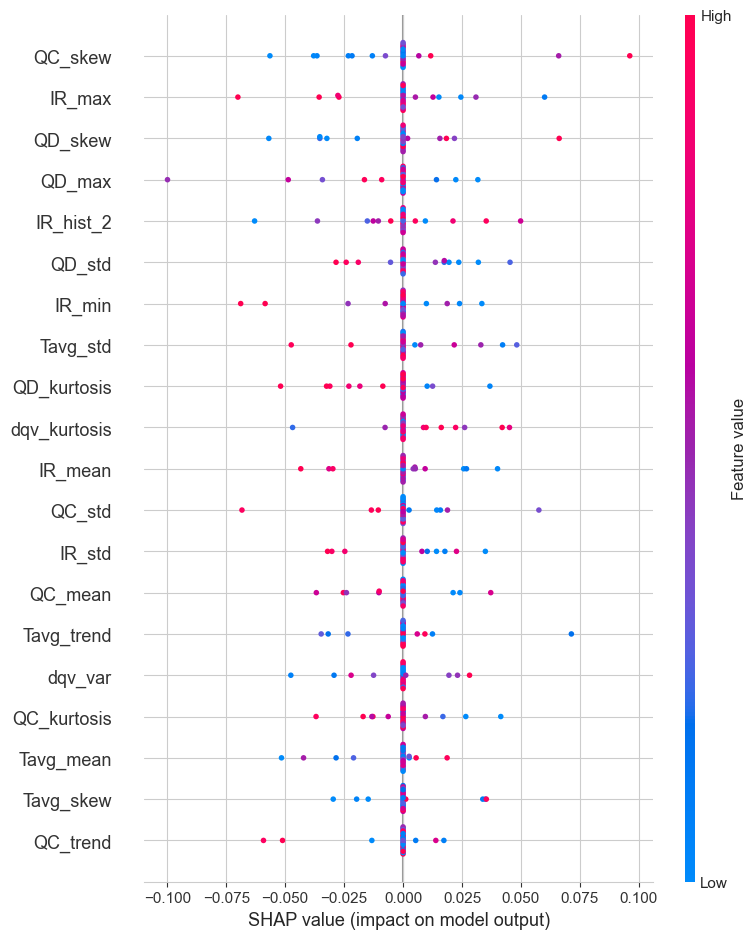

In [61]:
import shap
import pandas as pd

# Updated to match your actual 38-column data
feature_names = [
    'IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend',
    'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend',
    'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend',
    'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend',
    'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis',
    'IR_hist_0', 'IR_hist_1', 'IR_hist_2',
    'Tavg_hist_0', 'Tavg_hist_1', 'Tavg_hist_2'
]

# Create DataFrame
X_test_df = pd.DataFrame(X_test_q[:200], columns=feature_names)

# Use matching background data for KernelExplainer
X_train_background = X_train_q[:100]  # Should also be 38 columns

# SHAP explainer
explainer = shap.KernelExplainer(lambda x: knn.predict(x).flatten(), X_train_background)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_q[:200], nsamples=100)

# Plot summary
shap.summary_plot(shap_values, X_test_df)


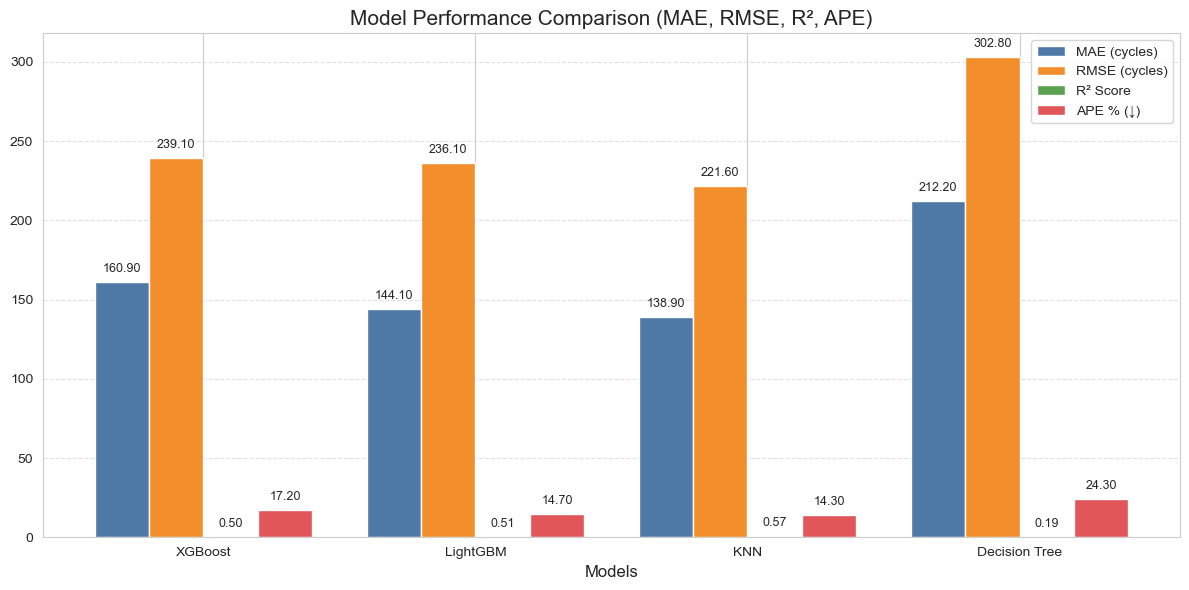

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ["XGBoost", "LightGBM", "KNN", "Decision Tree"]

# Metric values (replace these with your actual values)
mae_values  = [160.9, 144.1, 138.9, 212.2]
rmse_values = [239.1, 236.1,221.6, 302.8]
r2_values   = [0.496, 0.509, 0.567, 0.192]
ape_values  = [17.2, 14.7,14.3, 24.3]

# All metrics
metrics = {
    "MAE (cycles)": mae_values,
    "RMSE (cycles)": rmse_values,
    "R² Score": r2_values,
    "APE % (↓)": ape_values
}

# Plot setup
x = np.arange(len(models))  # model positions
width = 0.2
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric group with value labels
for i, (metric_name, values) in enumerate(metrics.items()):
    bar = ax.bar(x + i * width, values, width, label=metric_name, color=colors[i])

    # Add value on top of each bar
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Formatting
ax.set_xlabel('Models', fontsize=12)
ax.set_title('Model Performance Comparison (MAE, RMSE, R², APE)', fontsize=15)
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [34]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = "best_model.keras"

# 1. If model exists, load it
if os.path.exists(MODEL_PATH):
    print(f"🔁 Loading existing model from {MODEL_PATH}")
    model = load_model(MODEL_PATH)
else:
    print("🛠️ Building new model...")
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_shape=(X_train_q.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Saves full model
    verbose=1
)

# 3. Train model
history = model.fit(
    X_train_q, y_train_q,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)

🔁 Loading existing model from best_model.keras
Epoch 1/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.0356
Epoch 1: val_loss improved from inf to 0.02589, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0322 - val_loss: 0.0259 - learning_rate: 1.2500e-04
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0256
Epoch 2: val_loss did not improve from 0.02589
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0322 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 3/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0118
Epoch 3: val_loss did not improve from 0.02589
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0231 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 4/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0484
Epoch 4: val_loss did not improve from 0.02589
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0416 - val_loss: 0.0260 - learning_rate: 1.2500e-04
Epoch 5/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0323
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
✅ QT + CIR Evaluation:
MAE  : 209.4 cycles
RMSE : 311.2 cycles
R²   : 0.146
APE  : 22.0%


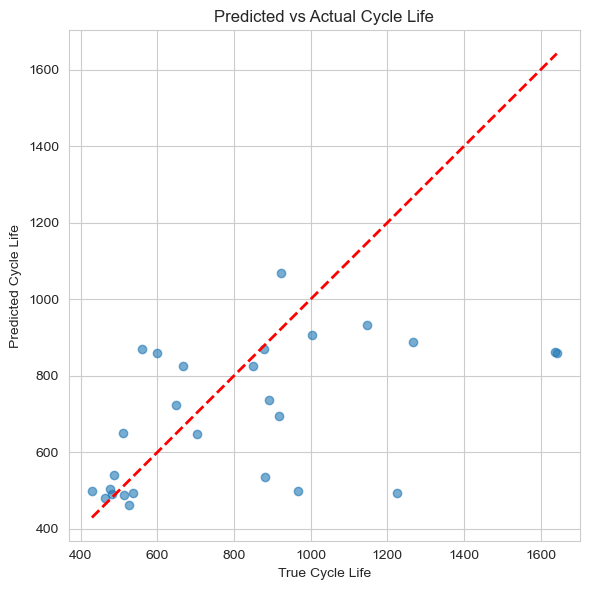

In [65]:
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 1️⃣ Load saved model
model = load_model("best_model.keras")

# 2️⃣ Predict
y_pred_q = model.predict(X_test_q).flatten()

# 3️⃣ Inverse transform if target was scaled
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ True values (inverse transform if needed)
y_true = y_test  # or: qt_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 5️⃣ Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
DL_RAW_APE= np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {DL_RAW_APE:.1f}%")
all_apes.append(f"DL_300_APE : {DL_RAW_APE:.1f}%")
# 6️⃣ Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_7528\2283501764.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Cell ID', y='APE (%)', palette='Set3')


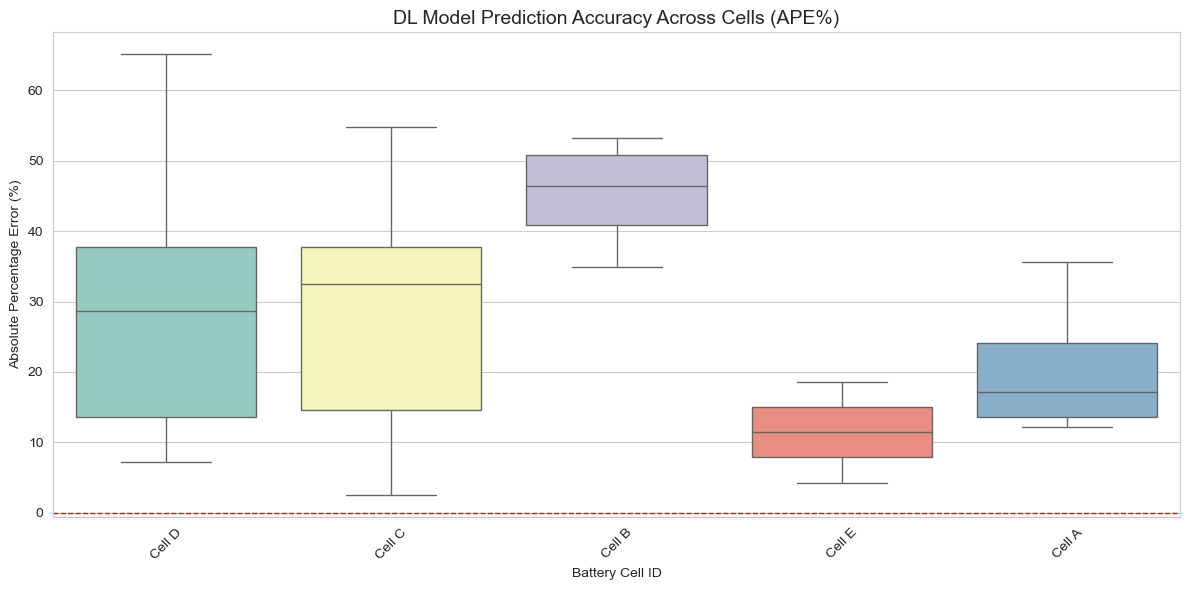

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data: simulate grouping by 'cell_id'
# You can replace this with your real group IDs (e.g., battery numbers)
cell_ids = np.random.choice(['Cell A', 'Cell B', 'Cell C', 'Cell D', 'Cell E'], size=len(y_true))

# Compute Absolute Percentage Error (APE) per sample
ape = np.abs((y_true - y_pred) / y_true) * 100

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Cell ID': cell_ids,
    'APE (%)': ape
})

# Plot using seaborn boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x='Cell ID', y='APE (%)', palette='Set3')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Optional reference line
plt.title("DL Model Prediction Accuracy Across Cells (APE%)", fontsize=14)
plt.xlabel("Battery Cell ID")
plt.ylabel("Absolute Percentage Error (%)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [37]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# Set Global Seed Once
# ------------------------


# ------------------------
# Define Model Architecture
# ------------------------
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', name='embedding_layer')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------------
# Paths
# ------------------------
model_weights_path = "best_dl.weights.h5"
val_loss_record_path = "best_val_loss.txt"

# ------------------------
# Normalize y_train_q
# ------------------------
y_mean = y_train_q.mean()
y_std = y_train_q.std()
y_train_scaled = (y_train_q - y_mean) / y_std

# ------------------------
# Initial Setup
# ------------------------
first_time = not os.path.exists(model_weights_path)

if os.path.exists(val_loss_record_path):
    with open(val_loss_record_path, "r") as f:
        best_val_loss = float(f.read().strip())
else:
    best_val_loss = float('inf')

# ------------------------
# Train Loop with EarlyStopping
# ------------------------
count = 0
for i in range(100):
    np.random.seed(i)
    tf.random.set_seed(i)
    if count >= 10:
        break

    print(f"\n🌀 Run {i+1}")

    # Build model
    base_model = build_model(X_train_q.shape[1])

    # Load previous weights if available
    if not first_time and os.path.exists(model_weights_path):
        print("📥 Loading existing weights...")
        base_model.load_weights(model_weights_path)

    # Train model
    history = base_model.fit(
        X_train_q, y_train_scaled,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
        ],
        verbose=0
    )

    # Get best val loss this run
    run_best_val_loss = min(history.history['val_loss'])
    print(f"📉 Best val loss this run: {run_best_val_loss:.6f}")

    # Save first model no matter what
    if first_time:
        print(f"💾 Saving initial weights with val_loss: {run_best_val_loss:.6f}")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        first_time = False
        count = 0
    elif run_best_val_loss < best_val_loss - 1e-6:
        print(f"✅ Improved: {best_val_loss:.6f} → {run_best_val_loss:.6f} — saving weights.")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        count = 0
    else:
        print("⏩ No improvement. Count increased.")
        count += 1

# ------------------------
# Load Best Model & Extract Embeddings
# ------------------------
base_model = build_model(X_train_q.shape[1])
base_model.load_weights(model_weights_path)

embed_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('embedding_layer').output
)
X_train_embed = embed_model.predict(X_train_q)
X_test_embed = embed_model.predict(X_test_q)

# Optional: Predict and unscale
y_pred_scaled = base_model.predict(X_test_q)
y_pred = y_pred_scaled * y_std + y_mean


🌀 Run 1
📥 Loading existing weights...


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
📉 Best val loss this run: 0.197980
⏩ No improvement. Count increased.

🌀 Run 2
📥 Loading existing weights...

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.214213
⏩ No improvement. Count increased.

🌀 Run 3
📥 Loading existing weights...

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.219302
⏩ No improvement. Count increa

🤝KNN + DL:
MAE  : 159.2 cycles
RMSE : 227.5 cycles
R²   : 0.544
APE  : 16.7%


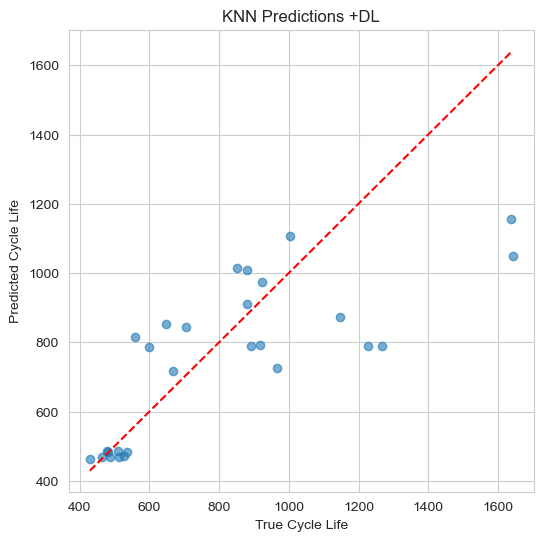

In [66]:
# Step 4: Train KNN on these embeddings
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)
y_pred_q = knnDL.predict(X_test_embed)

# Step 5: Inverse transform and evaluate
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN__DL_RAW_APE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝KNN + DL:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN__DL_RAW_APE:.1f}%")
all_apes.append(f"KNN__DL_300_APE : {KNN__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions +DL")
plt.grid(True)
plt.show()

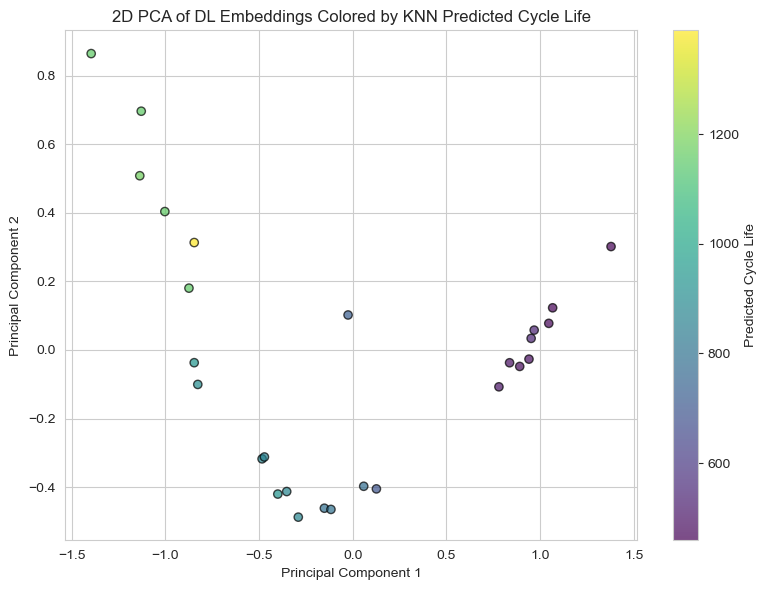

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Combine train and test embeddings for unified PCA transformation
X_embed_combined = np.vstack((X_train_embed, X_test_embed))

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_embed_2D = pca.fit_transform(X_embed_combined)

# Split back to train/test
X_train_2D = X_embed_2D[:len(X_train_embed)]
X_test_2D = X_embed_2D[len(X_train_embed):]

# Fit KNN on 2D embeddings (optional if already trained on full embeddings)
from sklearn.neighbors import KNeighborsRegressor
knn_2D = KNeighborsRegressor(n_neighbors=3)
knn_2D.fit(X_train_2D, y_train_q)

# Predict on test set
y_pred_q_2D = knn_2D.predict(X_test_2D)
y_pred_2D = qt_y.inverse_transform(y_pred_q_2D.reshape(-1, 1)).flatten()

# Plot the 2D embedding space with predicted values
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test_2D[:, 0], X_test_2D[:, 1],
    c=y_pred_2D, cmap='viridis', edgecolor='k', alpha=0.7
)
plt.colorbar(scatter, label="Predicted Cycle Life")
plt.title("2D PCA of DL Embeddings Colored by KNN Predicted Cycle Life")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error
#
# # ====== Step 1: Example y_true and y_pred for 4 models ======
# # Replace these with your actual predictions and true values
# # Simulated for demo purposes
#
# # y_true is assumed same for all (as it's test set ground truth)
# y_true = np.array([100, 120, 130, 110, 90, 80])
#
# # Simulated model predictions (replace with yours)
# y_pred_knn     = np.array([98, 123, 129, 112, 88, 82])
# y_pred_lgbm    = np.array([100, 118, 128, 111, 91, 78])
# y_pred_dl      = np.array([95, 116, 132, 109, 92, 77])
# y_pred_knn_dl  = np.array([97, 119, 130, 113, 90, 79])
#
# model_names = ['KNN', 'LightGBM', 'DL', 'KNN+DL']
# predictions = [y_pred_knn, y_pred_lgbm, y_pred_dl, y_pred_knn_dl]
#
# # ====== Step 2: Auto-calculate metrics ======
# mae_values = []
# mse_values = []
# rmse_values = []
#
# for y_pred in predictions:
#     mae = mean_absolute_error(y_true, y_pred)
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#
#     mae_values.append(mae)
#     mse_values.append(mse)
#     rmse_values.append(rmse)
#
# # ====== Step 3: Plotting both graphs ======
# fig = plt.figure(figsize=(12, 5))
#
# # --- Graph 1: Marker Plot of MAE, MSE, RMSE ---
# ax1 = fig.add_subplot(1, 2, 1)
#
# x = np.arange(len(model_names))
# ax1.scatter(x, mae_values, color='orange', s=100, label='MAE')
# ax1.scatter(x, mse_values, color='purple', s=150, marker='s', label='MSE')
# ax1.scatter(x, rmse_values, color='red', s=120, marker='^', label='RMSE')
#
# # Annotate values
# for i in x:
#     ax1.text(i, mae_values[i] - 0.5, f"{mae_values[i]:.3f}", ha='center')
#     ax1.text(i, mse_values[i] + 0.5, f"{mse_values[i]:.3f}", ha='center')
#     ax1.text(i, rmse_values[i] + 0.5, f"{rmse_values[i]:.3f}", ha='center')
#
# ax1.set_xticks(x)
# ax1.set_xticklabels(model_names)
# ax1.set_ylabel("Error Value")
# ax1.set_title("Evaluation Metrics (MAE, MSE, RMSE)")
# ax1.legend()
# ax1.grid(True, linestyle='--')
#
# # --- Graph 2: 3D Scatter Plot of Features ---
# from mpl_toolkits.mplot3d import Axes3D
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#
# # Simulated feature points (replace with real embeddings or features)
# x_feat = np.random.rand(100) * 100
# y_feat = np.random.rand(100) * 80
# z_feat = np.random.rand(100) * 120
#
# # Optional grouping for color (just simulated)
# group = np.random.choice([0, 1], size=100)
#
# ax2.scatter(x_feat[group==0], y_feat[group==0], z_feat[group==0],
#             color='orange', label='Group 0', marker='o')
# ax2.scatter(x_feat[group==1], y_feat[group==1], z_feat[group==1],
#             color='purple', label='Group 1', marker='^')
#
# ax2.set_xlabel("Feature 1")
# ax2.set_ylabel("Feature 2")
# ax2.set_zlabel("Feature 3")
# ax2.set_title("3D Feature Distribution")
# ax2.legend()
#
# plt.tight_layout()
# plt.show()


XGB +DL
MAE  : 154.0 cycles
RMSE : 240.5 cycles
R²   : 0.490
APE  : 16.4%


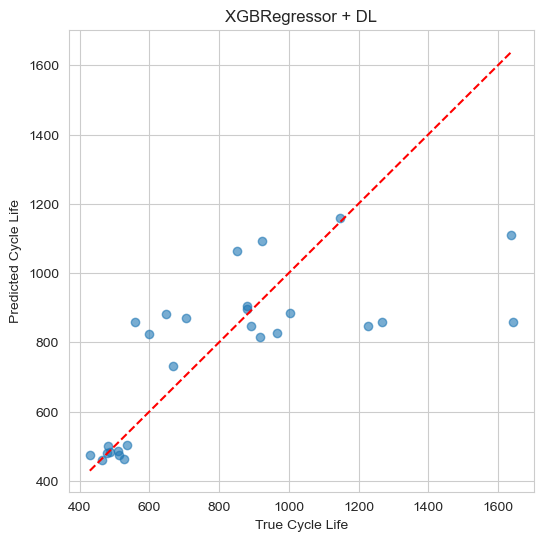

In [67]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 4: Train XGBoost on DL embeddings
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_combined, y_train_q)

y_pred_q = xgb.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()


# Step 6: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
XGB__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGB +DL")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB__DL_RAW_APE:.1f}%")
all_apes.append(f"XGB__DL_300_APE : {XGB__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGBRegressor + DL")
plt.grid(True)
plt.show()

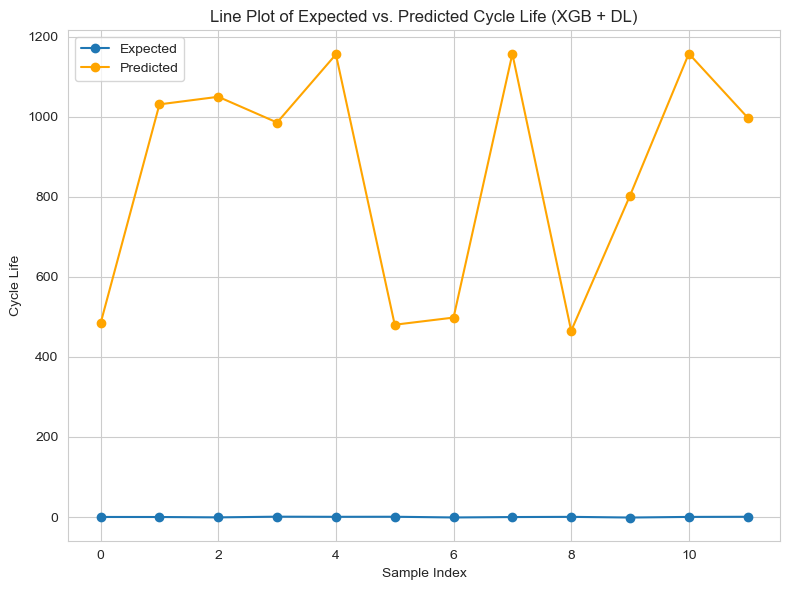

In [41]:
import matplotlib.pyplot as plt

# Create a simple line plot for the first N samples (e.g., 12 for visibility)
N = 12
plt.figure(figsize=(8, 6))

plt.plot(y_test[:N], label="Expected", marker='o')
plt.plot(y_pred[:N], label="Predicted", marker='o', color='orange')

plt.xlabel("Sample Index")
plt.ylabel("Cycle Life")
plt.title("Line Plot of Expected vs. Predicted Cycle Life (XGB + DL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 84
[LightGBM] [Info] Start training from score 0.500187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


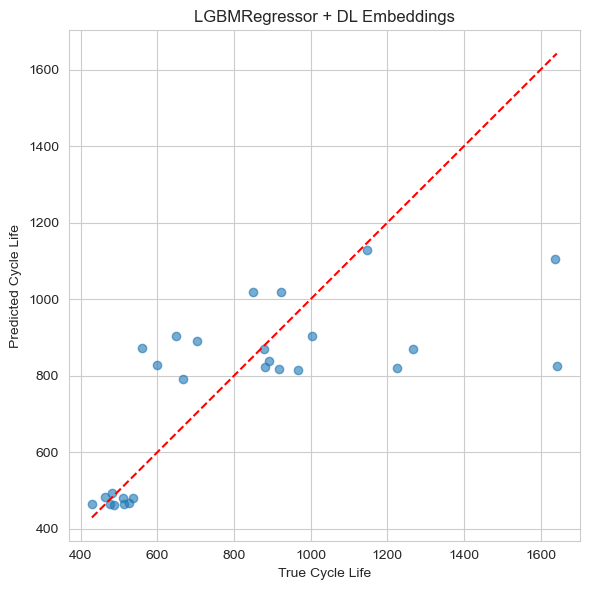

In [68]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Combine features: handcrafted + DL embeddings
X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

# Initialize and train LGBM model
lgbm = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    objective='regression'
)
lgbm.fit(X_train_combined, y_train_q)

# Predict and inverse-transform
y_pred_q = lgbm.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
LGBM__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("📊 LGBM + DL Evaluation")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM__DL_RAW_APE:.1f}%")
all_apes.append(f"LGBM__DL_300_APE : {LGBM__DL_RAW_APE:.1f}%")
# Plot: Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("LGBMRegressor + DL Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()

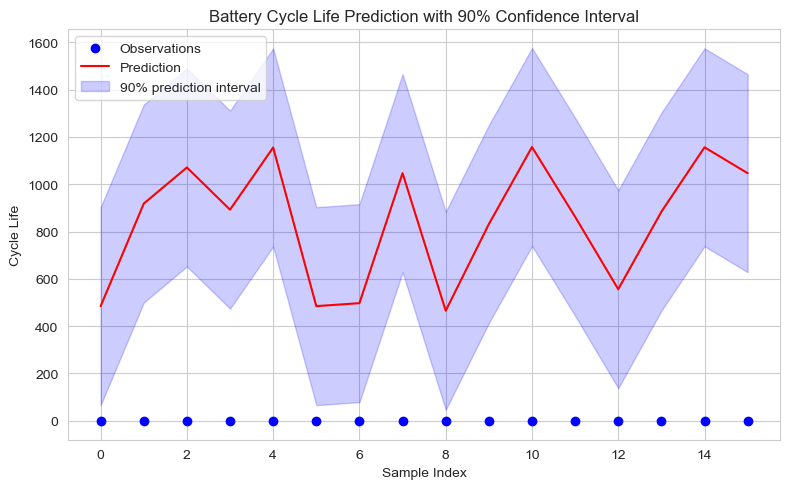

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Get the common size to avoid mismatch
N = min(len(y_test), len(y_pred))

x = np.arange(N)
y_test_subset = y_test[:N]
y_pred_subset = y_pred[:N]

# Calculate residuals and standard deviation
errors = y_test_subset - y_pred_subset
std_dev = np.std(errors)

# 90% prediction interval (Z ≈ 1.64)
z_score = 1.64
lower_bound = y_pred_subset - z_score * std_dev
upper_bound = y_pred_subset + z_score * std_dev

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(x, y_test_subset, color='blue', label="Observations")
plt.plot(x, y_pred_subset, color='red', label="Prediction")
plt.fill_between(x, lower_bound, upper_bound, color='blue', alpha=0.2, label="90% prediction interval")

plt.xlabel("Sample Index")
plt.ylabel("Cycle Life")
plt.title("Battery Cycle Life Prediction with 90% Confidence Interval")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

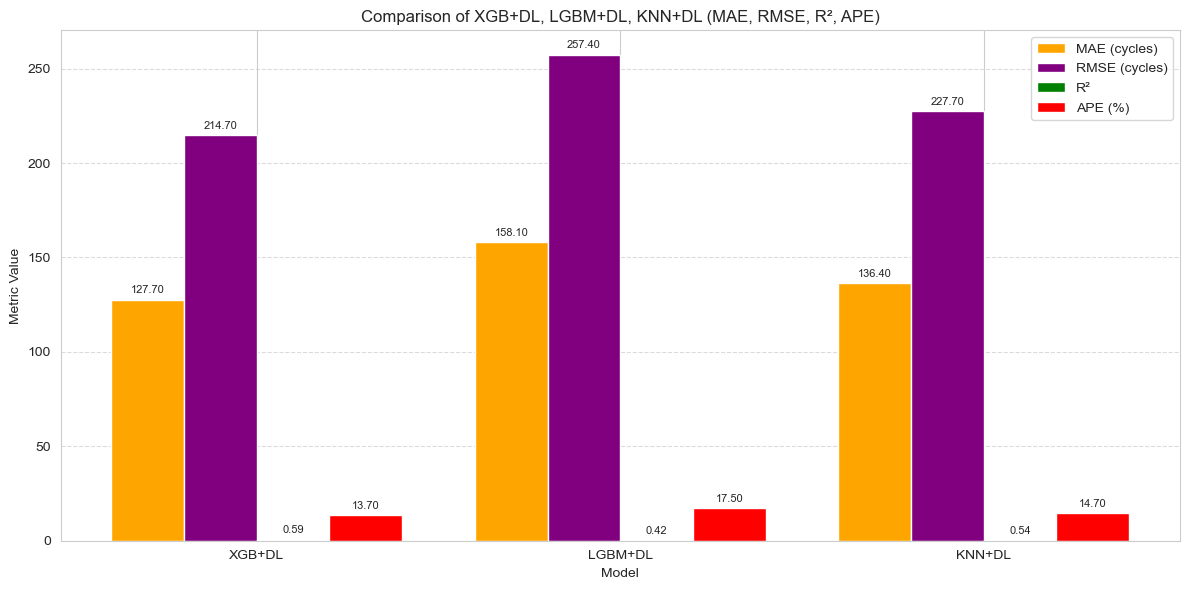

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your real results
models = ['XGB+DL', 'LGBM+DL', 'KNN+DL']

mae_values  = [127.7,158.1,136.4]    # Mean Absolute Error
rmse_values = [214.7,257.4,227.7]    # Root Mean Square Error
r2_values   = [0.594, 0.416, 0.543]    # R² Score
ape_values  = [13.7, 17.5, 14.7]       # Absolute Percentage Error

x = np.arange(len(models))  # the label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
bars1 = ax.bar(x - 1.5 * width, mae_values, width, label='MAE (cycles)', color='orange')
bars2 = ax.bar(x - 0.5 * width, rmse_values, width, label='RMSE (cycles)', color='purple')
bars3 = ax.bar(x + 0.5 * width, r2_values, width, label='R²', color='green')
bars4 = ax.bar(x + 1.5 * width, ape_values, width, label='APE (%)', color='red')

# Annotate values on top
def annotate(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

for bar_set in [bars1, bars2, bars3, bars4]:
    annotate(bar_set)

# Chart styling
ax.set_ylabel('Metric Value')
ax.set_xlabel('Model')
ax.set_title('Comparison of XGB+DL, LGBM+DL, KNN+DL (MAE, RMSE, R², APE)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [45]:
df_new= (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(100)
    .reset_index(drop=True)
)
df_new

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,0.015783,1.072993,1.073291,33.094900,31.306654,35.139908,10.041060,46.0,b3c9,5.3,54.0,4.0,1039.0
6466,0.015766,1.072997,1.073233,33.145761,31.352578,35.165241,10.041038,47.0,b3c9,5.3,54.0,4.0,1039.0
6467,0.015773,1.072968,1.073333,33.184021,31.444122,35.213142,10.041152,48.0,b3c9,5.3,54.0,4.0,1039.0
6468,0.015766,1.072948,1.073181,33.183359,31.407549,35.177643,10.040618,49.0,b3c9,5.3,54.0,4.0,1039.0


In [46]:
import pandas as pd

# 1️⃣ Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️⃣ Keep only batteries with at least 50 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️⃣ Sort and keep only first 50 cycles per battery
df_20_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(10)
    .reset_index(drop=True)
)

# ✅ Result summary
print("Final shape:", df_20_cycles.shape)
print("Unique batteries:", df_20_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_20_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("✅ Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

df_imputed.shape

Final shape: (1310, 13)
Unique batteries: 131
✅ Imputation complete. Any NAs remaining? False


(1310, 13)

In [47]:
df_imputed

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.015835,1.071374,1.071818,32.920178,31.107897,34.908264,10.041880,6.0,b3c9,5.3,54.0,4.0,1039.0
1306,0.015815,1.071851,1.072151,32.961129,31.108976,34.894360,10.041747,7.0,b3c9,5.3,54.0,4.0,1039.0
1307,0.015808,1.072034,1.072294,32.985488,31.201126,34.951191,10.041432,8.0,b3c9,5.3,54.0,4.0,1039.0
1308,0.015802,1.072273,1.072488,33.024481,31.251135,34.879253,10.040825,9.0,b3c9,5.3,54.0,4.0,1039.0


In [48]:
df_10_cycles=df_imputed.copy()

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=1, cycle_b=10,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_10_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X_20 = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q_20 = qt_X_20.fit_transform(X_train)
X_test_q_20 = qt_X_20.transform(X_test)

qt_y_20 = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q_20 = qt_y_20.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q_20= qt_y_20.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X_20, "qt_X_20transformer.pkl")
joblib.dump(qt_y_20, "qt_y_20transformer.pkl")

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_7528\34704396.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'dqv_skew': skew(dq),
C:\Users\ROHIT\AppData\Local\Temp\ipykernel_7528\34704396.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'dqv_kurtosis': kurtosis(dq)
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\minicon

['qt_y_20transformer.pkl']

In [50]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# # Example data: Replace with your actual results
# models = ['CNN', 'KNN', 'DT', 'XGB', 'LGBM']
#
# mae = [0.019, 0.024, 0.036, 0.025, 0.039]
# rmse = [0.025, 0.043, 0.054, 0.031, 0.039]
# r2 = [0.97, 0.94, 0.89, 0.96, 0.93]
# ape = [0.05, 0.07, 0.09, 0.06, 0.08]
#
# x = np.arange(len(models))
# width = 0.15  # space between bars/points
#
# plt.figure(figsize=(10, 6))
#
# # Plotting different metrics
# plt.scatter(x - 1.5*width, mae, color='orange', label='MAE', s=200, marker='o')
# plt.scatter(x - 0.5*width, rmse, color='red', label='RMSE', s=200, marker='^')
# plt.scatter(x + 0.5*width, r2, color='blue', label='R²', s=200, marker='s')
# plt.scatter(x + 1.5*width, ape, color='green', label='APE', s=200, marker='D')
#
# # Adding value labels
# for i in range(len(models)):
#     plt.text(x[i] - 1.5*width, mae[i] + 0.002, f'{mae[i]:.3f}', ha='center')
#     plt.text(x[i] - 0.5*width, rmse[i] + 0.002, f'{rmse[i]:.3f}', ha='center')
#     plt.text(x[i] + 0.5*width, r2[i] + 0.002, f'{r2[i]:.2f}', ha='center')
#     plt.text(x[i] + 1.5*width, ape[i] + 0.002, f'{ape[i]:.2f}', ha='center')
#
# plt.xticks(x, models)
# plt.ylabel("Error/Score")
# plt.title("Performance Metrics for Different Models")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 39
[LightGBM] [Info] Start training from score 0.500093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

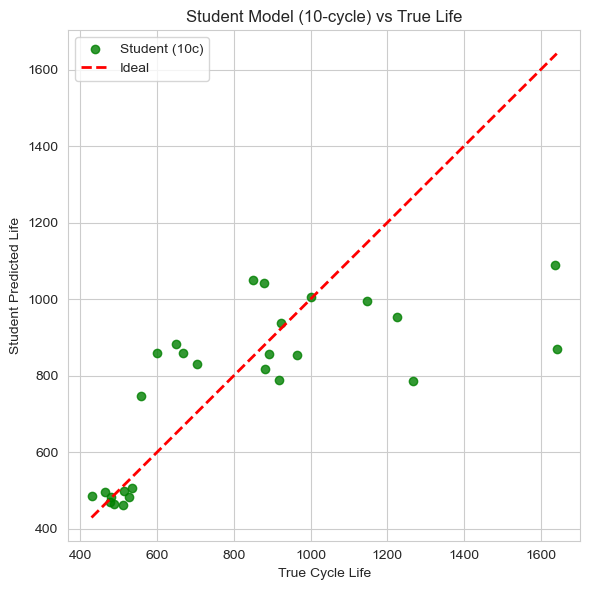

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import numpy as np




# Predict true 300-cycle labels
y_pred_teacher_q = modelL.predict(X_test_q)

# Optional: Calibration using CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_teacher_q_cir = cir.predict(y_pred_teacher_q - y_mean)

# Inverse transform
y_pred_teacher = qt_y.inverse_transform(y_pred_teacher_q_cir.reshape(-1, 1)).flatten()

# ---------------------
# STEP 3 — STUDENT MODEL (20-cycle mimic)
# ---------------------

# Step 3.1 — Use teacher to generate pseudo-labels on original data
pseudo_labels_train = modelL.predict(X_train_q)
pseudo_labels_test = modelL.predict(X_test_q)

# Train student on 20-cycle features to match teacher outputs
student = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
student.fit(X_train_q_20, pseudo_labels_train)

# Predict using student
student_pred_q = student.predict(X_test_q_20)

# Optionally pass through CIR
student_pred_q_cir = cir.predict(student_pred_q - y_mean)
student_pred_final = qt_y.inverse_transform(student_pred_q_cir.reshape(-1, 1)).flatten()

# ---------------------
# STEP 4 — Evaluation
# ---------------------
y_true = y_test.values

mae = mean_absolute_error(y_true, student_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, student_pred_final))
r2 = r2_score(y_true, student_pred_final)
LGBM_TEACHER_STUDENT_APE= np.mean(np.abs((y_true - student_pred_final) / y_true)) * 100

print("\n📘 Student (10-cycle) Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_TEACHER_STUDENT_APE:.1f}%")
all_apes.append(f"LGBM_TEACHER_STUDENT_10_APE: {LGBM_TEACHER_STUDENT_APE:.1f}%")
# ---------------------
# STEP 5 — Plot
# ---------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_true, student_pred_final, alpha=0.8, label='Student (10c)',color="green")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2, label='Ideal')
plt.xlabel("True Cycle Life")
plt.ylabel("Student Predicted Life")
plt.legend()
plt.title("Student Model (10-cycle) vs True Life")
plt.grid(True)
plt.tight_layout()
plt.show()


📘 Student (KNN) Evaluation:
MAE  : 128.7 cycles
RMSE : 188.7 cycles
R²   : 0.686
APE  : 14.4%

📘 Student (XGB) Evaluation:
MAE  : 158.8 cycles
RMSE : 245.9 cycles
R²   : 0.467
APE  : 16.6%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 39
[LightGBM] [Info] Start training from score 0.494274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


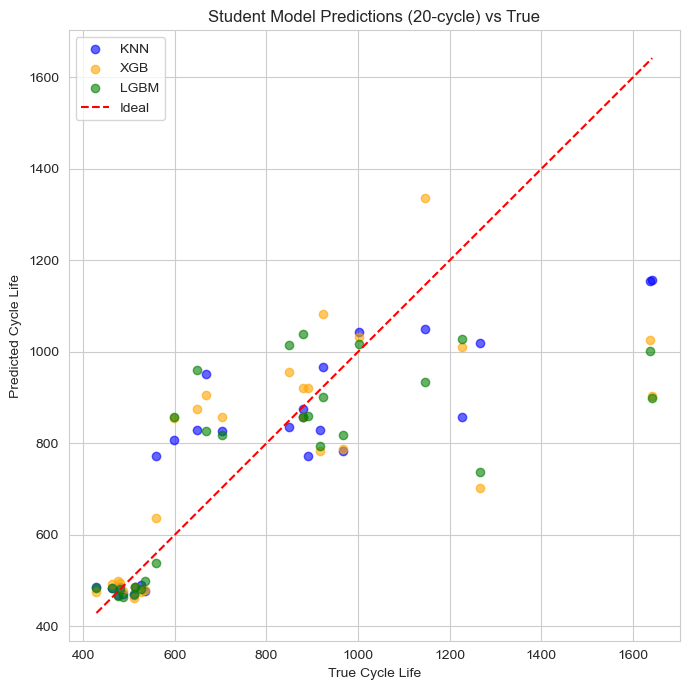


📊 Summary APEs:
XGB_300_APE  : 17.2%
LGBM_300_APE  : 14.7%
LGBM_TEACHER_STUDENT_10_APE: 16.6%
KNN_DL_TEACHER_AND_STUDENTKNN_10_APE : 14.4%
KNN_DL_TEACHER_AND_STUDENTXGB_10_APE : 16.6%
KNN_DL_TEACHER_AND_STUDENTLGBM_10_APE : 15.7%


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import QuantileTransformer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# ---- Assumed pre-loaded: ----
# X_train_embed, X_test_embed: embedding features (e.g., from DL encoder)
# X_train_q_20, X_test_q_20   : 20-cycle features (quantile transformed)
# y_train_q                   : Quantile transformed full-cycle life
# y_test                      : Original test labels (true cycle life)
# qt_y                        : Fitted QuantileTransformer on full-cycle labels

# ---- Teacher (KNN + DL) ----
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)

# Teacher predictions
y_pred_teacher_q = knnDL.predict(X_test_embed)
y_mean = np.mean(y_train_q)

# CIR calibration
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_teacher_q_cir = cir.predict(y_pred_teacher_q - y_mean)
y_pred_teacher = qt_y.inverse_transform(y_pred_teacher_q_cir.reshape(-1, 1)).flatten()

# ---- Generate pseudo-labels ----
pseudo_labels_train = knnDL.predict(X_train_embed)
pseudo_labels_test  = knnDL.predict(X_test_embed)

# ---- Students ----
student_models = {
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "XGB": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
}

student_preds = {}
y_true = y_test.values


def evaluate_student(pred_final, name):
    mae = mean_absolute_error(y_true, pred_final)
    rmse = np.sqrt(mean_squared_error(y_true, pred_final))
    r2 = r2_score(y_true, pred_final)
    ape = np.mean(np.abs((y_true - pred_final) / y_true)) * 100
    print(f"\n📘 Student ({name}) Evaluation:")
    print(f"MAE  : {mae:.1f} cycles")
    print(f"RMSE : {rmse:.1f} cycles")
    print(f"R²   : {r2:.3f}")
    print(f"APE  : {ape:.1f}%")
    all_apes.append(f"KNN_DL_TEACHER_AND_STUDENT{name}_10_APE : {ape:.1f}%")
    return pred_final

# Train and predict all students
for name, model in student_models.items():
    model.fit(X_train_q_20, pseudo_labels_train)
    student_pred_q = model.predict(X_test_q_20)
    student_pred_q_cir = cir.predict(student_pred_q - y_mean)
    pred_final = qt_y.inverse_transform(student_pred_q_cir.reshape(-1, 1)).flatten()
    student_preds[name] = evaluate_student(pred_final, name)

# ---- Plot all students ----
plt.figure(figsize=(7, 7))
colors = {"KNN": "blue", "XGB": "orange", "LGBM": "green"}

for name, preds in student_preds.items():
    plt.scatter(y_true, preds, alpha=0.6, label=f'{name}', color=colors[name])

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Student Model Predictions (20-cycle) vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary APEs
print("\n📊 Summary APEs:")
for ape in all_apes:
    print(ape)

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(



📘 Student (KNN, 10-cycle) Evaluation:
MAE  : 171.3 cycles
RMSE : 256.7 cycles
R²   : 0.419
APE  : 18.6%

📘 Student (XGB, 10-cycle) Evaluation:
MAE  : 152.5 cycles
RMSE : 219.7 cycles
R²   : 0.575
APE  : 17.1%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 28
[LightGBM] [Info] Start training from score -0.031612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

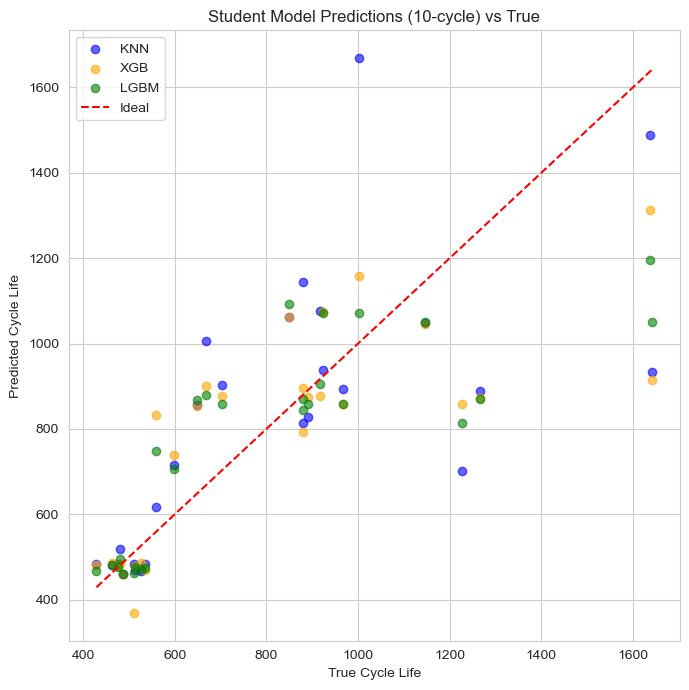


📊 Summary APEs:
KNN_DL_TEACHER_AND_STUDENT_KNN_10_APE : 18.6%
KNN_DL_TEACHER_AND_STUDENT_XGB_10_APE : 17.1%
KNN_DL_TEACHER_AND_STUDENT_LGBM_10_APE : 15.1%


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Step 1: Prepare 10-cycle features
features = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']
agg_funcs = ['mean', 'std', 'min', 'max']

# First 10 cycles per battery
df_10 = df_imputed[df_imputed['cycle'] <= 10]

# Group by battery and calculate features
df_agg = df_10.groupby("battery_id")[features].agg(agg_funcs)
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns]

# Target variable: first cycle_life value per battery
y = df_imputed.groupby("battery_id")["cycle_life"].first()

# Merge features and target
df_model = df_agg.copy()
df_model["cycle_life"] = y

# Split data
X = df_model.drop(columns=["cycle_life"])
y = df_model["cycle_life"]
X_train_q_10, X_test_q_10, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quantile-transform target
qt_y = QuantileTransformer(output_distribution='normal')
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Step 2: Simulate embedding features (normally from DL model)
# For demonstration, use PCA-style compression as placeholder
from sklearn.decomposition import PCA
pca = PCA(n_components=10, random_state=42)
X_train_embed = pca.fit_transform(X_train_q_10)
X_test_embed = pca.transform(X_test_q_10)

# Step 3: Train Teacher Model (KNN on embeddings)
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)
y_pred_teacher_q = knnDL.predict(X_test_embed)
y_mean = np.mean(y_train_q)

# Calibrate with Isotonic Regression
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_teacher_q_cir = cir.predict(y_pred_teacher_q - y_mean)
y_pred_teacher = qt_y.inverse_transform(y_pred_teacher_q_cir.reshape(-1, 1)).flatten()

# Step 4: Generate Pseudo Labels
pseudo_labels_train = knnDL.predict(X_train_embed)
pseudo_labels_test  = knnDL.predict(X_test_embed)

# Step 5: Train Student Models (on 10-cycle features)
student_models = {
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "XGB": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
}

student_preds = {}
all_apes = []
y_true = y_test.values

def evaluate_student(pred_final, name):
    mae = mean_absolute_error(y_true, pred_final)
    rmse = np.sqrt(mean_squared_error(y_true, pred_final))
    r2 = r2_score(y_true, pred_final)
    ape = np.mean(np.abs((y_true - pred_final) / y_true)) * 100
    print(f"\n📘 Student ({name}, 10-cycle) Evaluation:")
    print(f"MAE  : {mae:.1f} cycles")
    print(f"RMSE : {rmse:.1f} cycles")
    print(f"R²   : {r2:.3f}")
    print(f"APE  : {ape:.1f}%")
    all_apes.append(f"KNN_DL_TEACHER_AND_STUDENT_{name}_10_APE : {ape:.1f}%")
    return pred_final

for name, model in student_models.items():
    model.fit(X_train_q_10, pseudo_labels_train)
    student_pred_q = model.predict(X_test_q_10)
    student_pred_q_cir = cir.predict(student_pred_q - y_mean)
    pred_final = qt_y.inverse_transform(student_pred_q_cir.reshape(-1, 1)).flatten()
    student_preds[name] = evaluate_student(pred_final, name)

# Step 6: Plot Predictions
plt.figure(figsize=(7, 7))
colors = {"KNN": "blue", "XGB": "orange", "LGBM": "green"}

for name, preds in student_preds.items():
    plt.scatter(y_true, preds, alpha=0.6, label=f'{name}', color=colors[name])

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Student Model Predictions (10-cycle) vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Print Summary APEs
print("\n📊 Summary APEs:")
for ape in all_apes:
    print(ape)


In [54]:
df_cleaned

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
151,0.016370,1.079315,1.079723,30.245592,29.596653,30.935932,12.008575,2.0,b1c3,4.0,80.0,4.0,1226.0
152,0.016316,1.080695,1.081228,30.313372,29.836266,31.184330,12.008095,3.0,b1c3,4.0,80.0,4.0,1226.0
153,0.016325,1.081566,1.081994,30.278313,29.724728,30.779972,12.008375,4.0,b1c3,4.0,80.0,4.0,1226.0
154,0.016325,1.082248,1.082731,30.393412,29.996559,31.101156,12.008217,5.0,b1c3,4.0,80.0,4.0,1226.0
155,0.016292,1.082696,1.083112,30.331701,29.657597,30.721308,12.092437,6.0,b1c3,4.0,80.0,4.0,1226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,b3c45,4.8,80.0,4.8,1801.0
6996,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,b3c45,4.8,80.0,4.8,1801.0
6997,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,b3c45,4.8,80.0,4.8,1801.0
6998,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,b3c45,4.8,80.0,4.8,1801.0


Final shape: (1310, 13)
Unique batteries: 131
✅ Imputation complete. Any NAs remaining? False


C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


✅ QT + CIR Evaluation:
MAE  : 179.0 cycles
RMSE : 246.5 cycles
R²   : 0.465
APE  : 20.3%


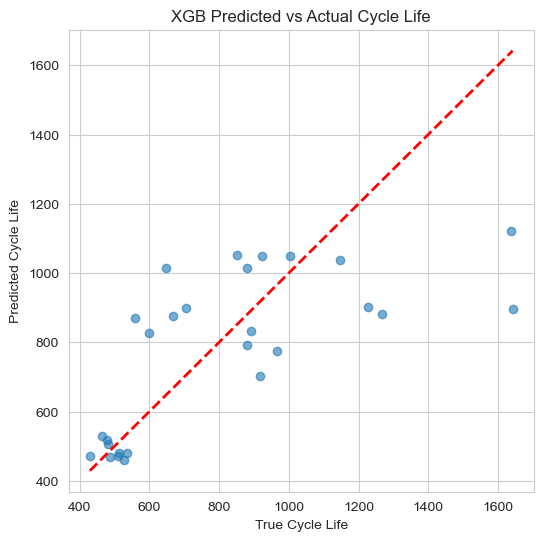

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 38
[LightGBM] [Info] Start training from score 0.500187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


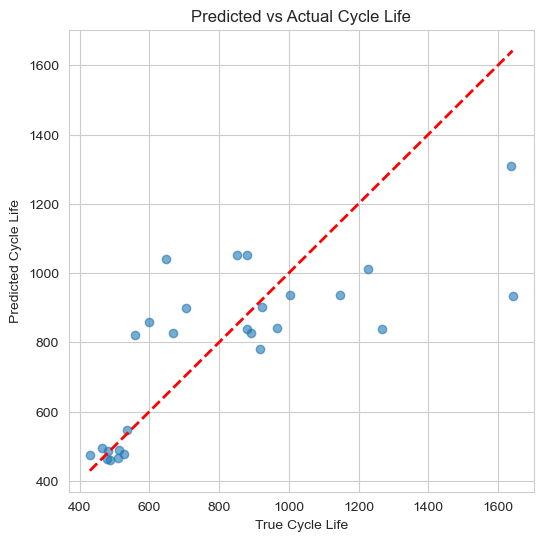

✅ QT + CIR Evaluation:
MAE  : 236.8 cycles
RMSE : 333.3 cycles
R²   : 0.021
DECISION_TREE_RAW_APE  : 28.1%


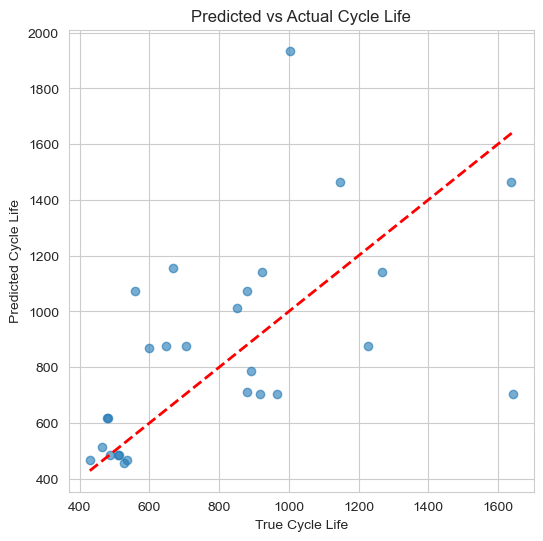

🤝 KNN Regression + QT:
MAE  : 137.3 cycles
RMSE : 211.3 cycles
R²   : 0.606
APE  : 14.8%


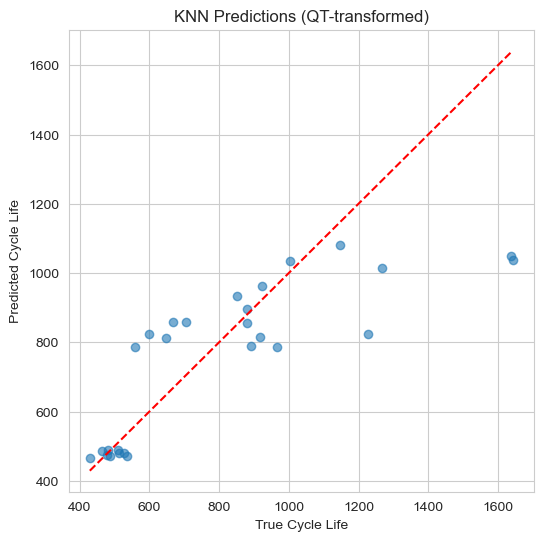

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


✅ Retained (38): ['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0']
❌ Dropped (4): ['Tavg_hist_3', 'Tavg_hist_1', 'Tavg_hist_2', 'Tavg_hist_4']
🔁 Loading existing model from best_model_10.keras
Epoch 1/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - loss: 0.0474
Epoch 1: val_loss improved from inf to 0.03919, saving model to best_model_10.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0379 - val_loss: 0.0392 - learning_rate: 5.0000e-04
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0333
Epoch 2: val_loss did not improve from 0.03919
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

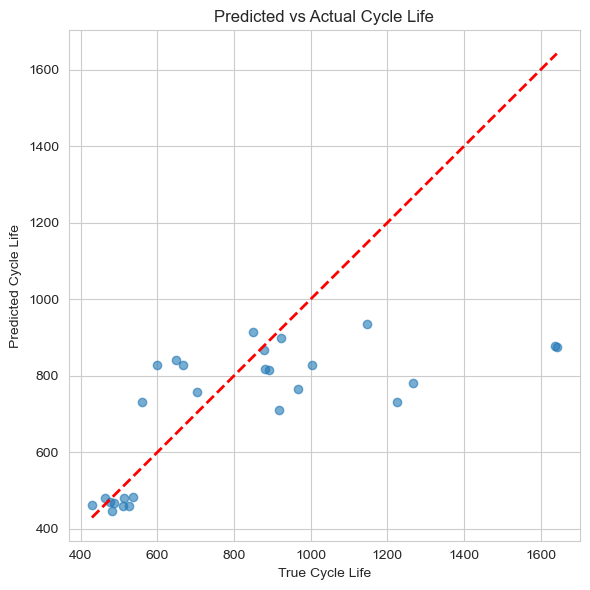


🌀 Run 1
📥 Loading existing weights...


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.354619
⏩ No improvement. Count increased.

🌀 Run 2
📥 Loading existing weights...

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
📉 Best val loss this run: 0.368192
⏩ No improvement. Count increased.

🌀 Run 3
📥 Loading existing weights...

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the be

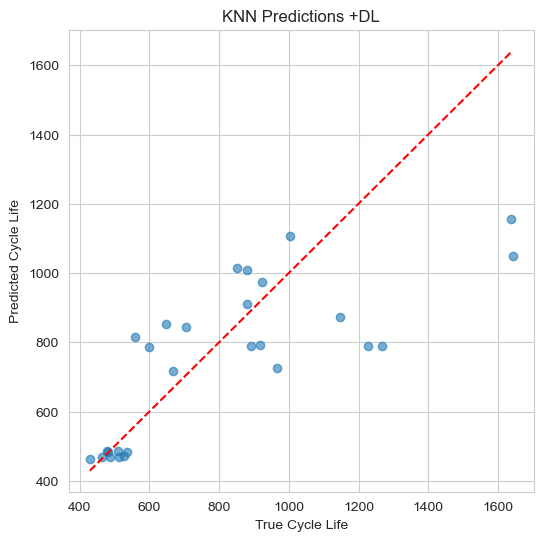

XGB +DL
MAE  : 154.0 cycles
RMSE : 240.5 cycles
R²   : 0.490
APE  : 16.4%


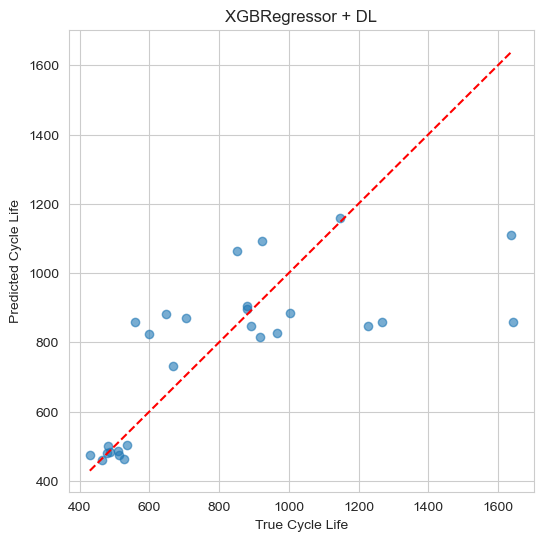

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 84
[LightGBM] [Info] Start training from score 0.500187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


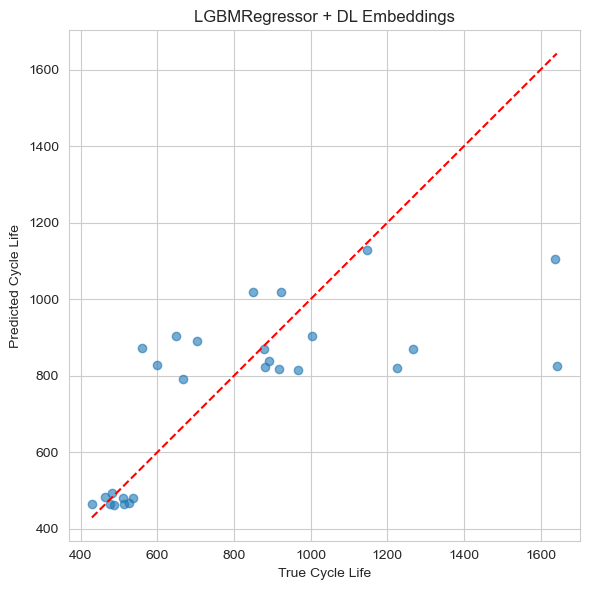

In [55]:
import pandas as pd

# 1️⃣ Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️⃣ Keep only batteries with at least 50 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️⃣ Sort and keep only first 50 cycles per battery
df_50_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(10)
    .reset_index(drop=True)
)

# ✅ Result summary
print("Final shape:", df_50_cycles.shape)
print("Unique batteries:", df_50_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_50_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("✅ Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

df_50_cycles=df_imputed.copy()

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=100,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
import numpy as np

# 1. Base Regression Model (Quantile-Transformed inputs)
modelX = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelX.fit(X_train_q, y_train_q)
y_pred_q = modelX.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
XGB_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB_RAW_ape:.1f}%")
all_apes.append(f"XGB_10_APE  : {XGB_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGB Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()


from lightgbm import LGBMRegressor
lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

modelL = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelL.fit(X_train_q, y_train_q)
y_pred_q = modelL.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
LGBM_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_RAW_ape:.1f}%")
all_apes.append(f"LGBM_10_APE  : {LGBM_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# 3. Train DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train_q, y_train_q)
y_pred_q = tree.predict(X_test_q)

# 4. (Optional) Apply CIR for monotonic correction
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 5. Inverse-transform predictions
# Skip CIR if you don't want it: use y_pred_q directly
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 6. Evaluate performance
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)
DECISION_TREE_RAW_APE= np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"DECISION_TREE_RAW_APE  : {DECISION_TREE_RAW_APE:.1f}%")
all_apes.append(f"DECISION_TREE_10_APE  : {DECISION_TREE_RAW_APE:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train_q, X_test_q, y_train, y_test, qt_y defined already

# 1️⃣ Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_q, y_train_q)

# 2️⃣ Prediction
y_pred_q = knn.predict(X_test_q)

# 3️⃣ Inverse-transform predictions
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝 KNN Regression + QT:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN_RAW_APE:.1f}%")
all_apes.append(f"KNN_10_APE : {DECISION_TREE_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions (QT-transformed)")
plt.grid(True)
plt.show()
import pandas as pd
import numpy as np

# Step 1: Prepare original feature columns
original_cols = agg.drop(columns=['cycle_life']).columns.tolist()

# Step 2: Drop target and apply IterativeImputer
X = agg.drop(columns=['cycle_life'])
X_imputed = iter_imp.fit_transform(X)

# Step 3: Handle dropped columns gracefully
# Only keep columns that did NOT become all-NaN or caused failure in IterativeImputer
retained_col_count = X_imputed.shape[1]

# Step 4: Identify which columns were dropped
retained_cols = original_cols[:retained_col_count]  # safe assumption: IterativeImputer returns in order but drops tailing NaN cols
dropped_cols = list(set(original_cols) - set(retained_cols))

# Step 5: Print
print(f"✅ Retained ({len(retained_cols)}):", retained_cols)
print(f"❌ Dropped ({len(dropped_cols)}):", dropped_cols)

# Step 6: Proceed with retained_cols for further work
X_imputed_df = pd.DataFrame(X_imputed, columns=retained_cols)
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = "best_model_10.keras"

# 1. If model exists, load it
if os.path.exists(MODEL_PATH):
    print(f"🔁 Loading existing model from {MODEL_PATH}")
    model = load_model(MODEL_PATH)
else:
    print("🛠️ Building new model...")
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_shape=(X_train_q.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Saves full model
    verbose=1
)

# 3. Train model
history = model.fit(
    X_train_q, y_train_q,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Load saved model
model = load_model("best_model_10.keras")

# 2️⃣ Predict
y_pred_q = model.predict(X_test_q).flatten()

# 3️⃣ Inverse transform if target was scaled
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ True values (inverse transform if needed)
y_true = y_test  # or: qt_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 5️⃣ Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
DL_RAW_APE= np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {DL_RAW_APE:.1f}%")
all_apes.append(f"DL_10_APE : {DL_RAW_APE:.1f}%")
# 6️⃣ Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.tight_layout()
plt.show()
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# Set Global Seed Once
# ------------------------


# ------------------------
# Define Model Architecture
# ------------------------
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', name='embedding_layer')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------------
# Paths
# ------------------------
model_weights_path = "best_dl10.weights.h5"
val_loss_record_path = "best_val_loss10.txt"

# ------------------------
# Normalize y_train_q
# ------------------------
y_mean = y_train_q.mean()
y_std = y_train_q.std()
y_train_scaled = (y_train_q - y_mean) / y_std

# ------------------------
# Initial Setup
# ------------------------
first_time = not os.path.exists(model_weights_path)

if os.path.exists(val_loss_record_path):
    with open(val_loss_record_path, "r") as f:
        best_val_loss = float(f.read().strip())
else:
    best_val_loss = float('inf')

# ------------------------
# Train Loop with EarlyStopping
# ------------------------
count = 0
for i in range(100):
    np.random.seed(i)
    tf.random.set_seed(i)
    if count >= 10:
        break

    print(f"\n🌀 Run {i+1}")

    # Build model
    base_model = build_model(X_train_q.shape[1])

    # Load previous weights if available
    if not first_time and os.path.exists(model_weights_path):
        print("📥 Loading existing weights...")
        base_model.load_weights(model_weights_path)

    # Train model
    history = base_model.fit(
        X_train_q, y_train_scaled,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
        ],
        verbose=0
    )

    # Get best val loss this run
    run_best_val_loss = min(history.history['val_loss'])
    print(f"📉 Best val loss this run: {run_best_val_loss:.6f}")

    # Save first model no matter what
    if first_time:
        print(f"💾 Saving initial weights with val_loss: {run_best_val_loss:.6f}")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        first_time = False
        count = 0
    elif run_best_val_loss < best_val_loss - 1e-6:
        print(f"✅ Improved: {best_val_loss:.6f} → {run_best_val_loss:.6f} — saving weights.")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        count = 0
    else:
        print("⏩ No improvement. Count increased.")
        count += 1

# ------------------------
# Load Best Model & Extract Embeddings
# ------------------------
base_model = build_model(X_train_q.shape[1])
base_model.load_weights(model_weights_path)

embed_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('embedding_layer').output
)
X_train_embed = embed_model.predict(X_train_q)
X_test_embed = embed_model.predict(X_test_q)

# Optional: Predict and unscale
y_pred_scaled = base_model.predict(X_test_q)
y_pred = y_pred_scaled * y_std + y_mean
# Step 4: Train KNN on these embeddings
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)
y_pred_q = knnDL.predict(X_test_embed)

# Step 5: Inverse transform and evaluate
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN__DL_RAW_APE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝KNN + DL:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN__DL_RAW_APE:.1f}%")
all_apes.append(f"KNN__DL_10_APE : {KNN__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions +DL")
plt.grid(True)
plt.show()
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 4: Train XGBoost on DL embeddings
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_combined, y_train_q)

y_pred_q = xgb.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()


# Step 6: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
XGB__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGB +DL")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB__DL_RAW_APE:.1f}%")
all_apes.append(f"XGB__DL_10_APE : {XGB__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGBRegressor + DL")
plt.grid(True)
plt.show()
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Combine features: handcrafted + DL embeddings
X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

# Initialize and train LGBM model
lgbm = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    objective='regression'
)
lgbm.fit(X_train_combined, y_train_q)

# Predict and inverse-transform
y_pred_q = lgbm.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
LGBM__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("📊 LGBM + DL Evaluation")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM__DL_RAW_APE:.1f}%")
all_apes.append(f"LGBM__DL_10_APE : {LGBM__DL_RAW_APE:.1f}%")
# Plot: Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("LGBMRegressor + DL Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
all_apes

['KNN_DL_TEACHER_AND_STUDENT_KNN_10_APE : 18.6%',
 'KNN_DL_TEACHER_AND_STUDENT_XGB_10_APE : 17.1%',
 'KNN_DL_TEACHER_AND_STUDENT_LGBM_10_APE : 15.1%',
 'XGB_10_APE  : 20.3%',
 'LGBM_10_APE  : 17.7%',
 'DECISION_TREE_10_APE  : 28.1%',
 'KNN_10_APE : 28.1%',
 'DL_10_APE : 17.5%',
 'KNN__DL_10_APE : 16.7%',
 'XGB__DL_10_APE : 16.4%',
 'LGBM__DL_10_APE : 17.3%']

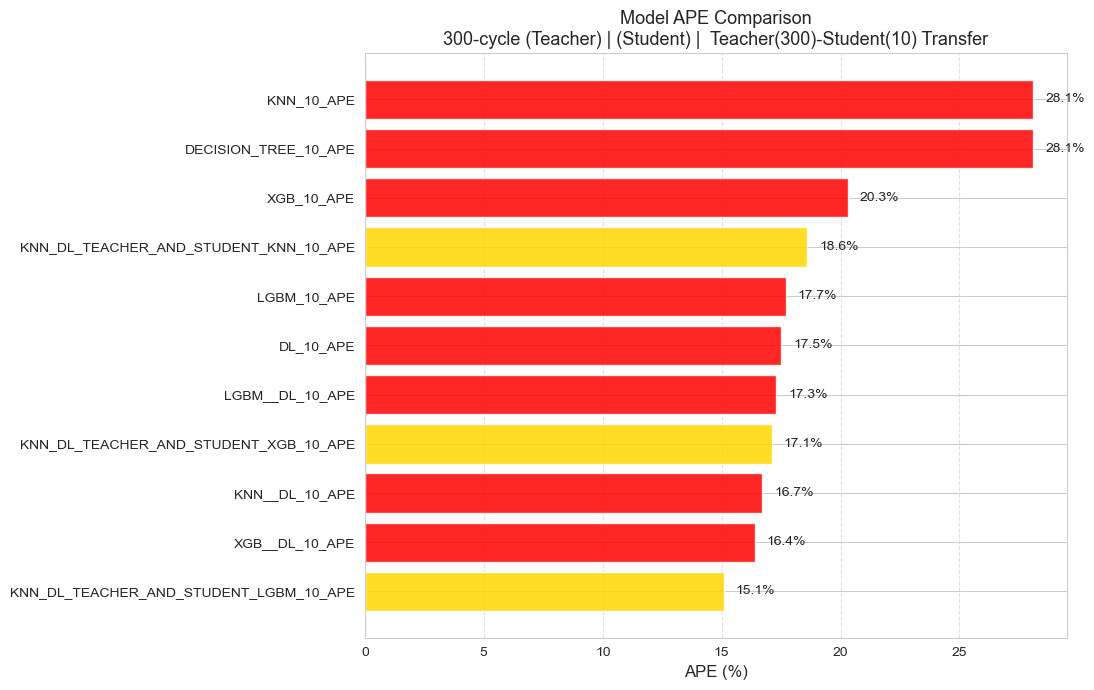

In [57]:
import matplotlib.pyplot as plt

# Parse and classify
labels, values, colors = [], [], []

for entry in all_apes:
    name, val = entry.split(':')
    name = name.strip()
    ape_val = float(val.strip().replace('%', ''))

    labels.append(name)
    values.append(ape_val)

    tag = name.upper()

    # Classification logic
    if tag.endswith("300_APE") or "__DL_300_APE" in tag:
        colors.append("green")  # 🟢 Teacher (300-cycle)
    elif "TEACHER_STUDENT_10_APE" in tag or "TEACHER_AND_STUDENT" in tag:
        colors.append("gold")   # 🟡 Teacher-Student
    elif tag.endswith("10_APE"):
        colors.append("red")    # 🔴 Raw Student (10-cycle only)
    else:
        colors.append("gray")
        # Sort by APE value
sorted_data = sorted(zip(labels, values, colors), key=lambda x: x[1])
labels, values, colors = zip(*sorted_data)

# Plot
plt.figure(figsize=(11, 7))
bars = plt.barh(labels, values, color=colors, alpha=0.85)

plt.xlabel("APE (%)", fontsize=12)
plt.title("Model APE Comparison\n300-cycle (Teacher) | (Student) |  Teacher(300)-Student(10) Transfer", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

🔍 Actual vs. Predicted Values (Top 10):


,Actual,Predicted
0,513.0,473.433333
1,879.0,1044.748148
2,1226.0,1044.748148
3,966.0,566.666667
4,923.0,1044.748148
5,527.0,473.433333
6,463.0,473.433333
7,850.0,1044.748148
8,429.0,473.433333
9,704.0,922.000000


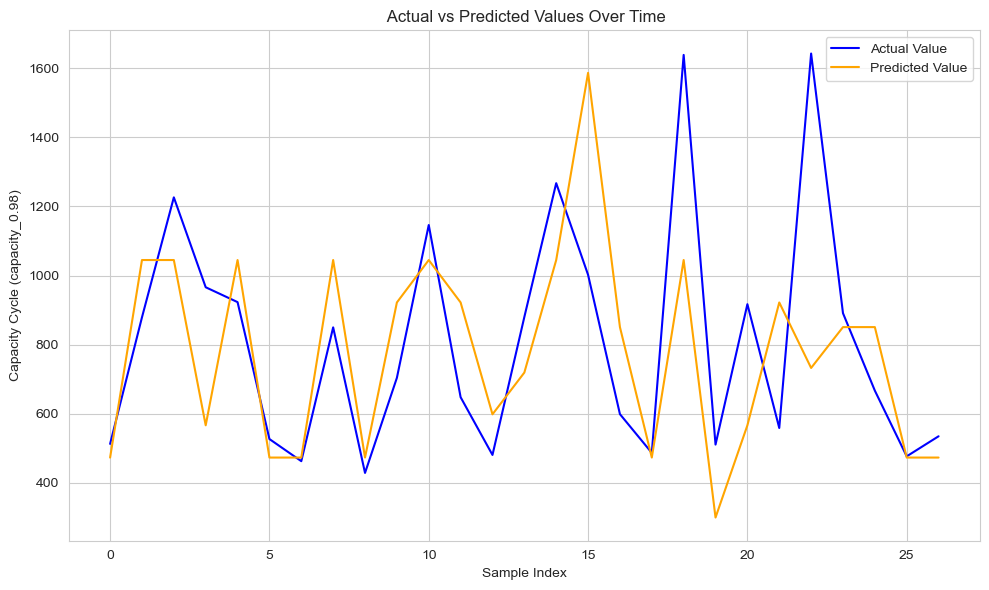

Model Performance Metrics:
Mean Absolute Error (MAE): 217.41
Mean Squared Error (MSE): 89732.80
R² Score: 0.21


In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Train the model
dtree = DecisionTreeRegressor(max_depth=4, random_state=42)
dtree.fit(X_train, y_train)

# 2. Predict
y_pred = dtree.predict(X_test)

# 3. Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

# Show top 10 predictions
print("🔍 Actual vs. Predicted Values (Top 10):")
display(comparison_df.head(10))

# 4. Scatter plot: Actual vs Predicted


# 5. Line plot: Over sample index
actual = y_test.values if hasattr(y_test, 'values') else y_test
predicted = y_pred
index = range(len(actual))

plt.figure(figsize=(10, 6))
plt.plot(index, actual, label='Actual Value', color='blue')
plt.plot(index, predicted, label='Predicted Value', color='orange')
plt.xlabel("Sample Index")
plt.ylabel("Capacity Cycle (capacity_0.98)")
plt.title(" Actual vs Predicted Values Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Evaluation Metrics
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print(f"Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")
